# Price Taker Class Loop Example

This file walks through the construction of a loop of price-taker model for solid oxide fuel cell (SOFC) evaluated within the ERCOT West, 2022 price market.

## Imports

The first cell imports all necessary functions. Notably, we need the FlowsheetBlock from idaes.core, the DesignModel and OperationModel from the multiperiod class, and the PriceTakerModel, also from the multiperiod class.

In [4]:
import logging
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
# from idaes.apps.grid_integration.multiperiod.price_taker_model import PriceTakerModel
from idaes.apps.grid_integration.pricetaker.price_taker_model import PriceTakerModel
from idaes.apps.grid_integration.pricetaker.design_and_operation_models import (
    DesignModel,
    OperationModel,
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
from concurrent.futures import ProcessPoolExecutor

The following is to check package import, which is not needed for actual running the code
when there's error from importing
1. check idaes version up-to-date or not, and restart kernel
2. check github example code about the exact line
3. check if the folder for the import module/function exist

In [5]:
# import idaes
# print(idaes.__version__)
# from idaes.apps.grid_integration.pricetaker.price_taker_model import PriceTakerModel
# import idaes.apps.grid_integration as gi
# print(dir(gi))

# Model Block components

## simple_flowsheet_func(m):
Dummy flowsheet function for testing

needed for m.build_multiperiod_model()

In [6]:
def simple_flowsheet_func(m):
    """Dummy flowsheet function for testing"""
    m.x = pyo.Var()
    m.y = pyo.Var()
    m.con1 = pyo.Constraint(expr=m.x + m.y == 1)
    m.LMP = pyo.Param(initialize=1, mutable=False)

    m.blk = pyo.Block()
    m.blk.power = pyo.Var()
    m.blk.op_mode = pyo.Var(within=pyo.Binary)
    m.blk.LMP = pyo.Param(initialize=1, mutable=False)

## Design Block

To utilize to price taker class, we first need to establish a design model and an operational model. First we will discuss the design model. The design model contains upper-level decisions that dictate whether the model is used, what maximum and minimum capacity for a commodity, and other relevant decisions. The two variables mentioned here will be used in the function below.

In this example, we utilize an hourly version of capital expenditures (CAPEX) and fixed operating and investment costs (FOM). However, we include them to be \$0.00 here for completeness.

In [7]:
def SOFC_design_model(
    m,
    max_power=None,
    min_power=None,
):
    # Capacity parameters; Minimum and Maximum power capacity given by the user
    m.PMAX = pyo.Param(initialize=max_power, mutable=False)
    m.PMIN = pyo.Param(initialize=min_power, mutable=False)
    m.capacity = pyo.Var()      
    m.install_unit = pyo.Var(initialize=1)
    m.install_unit.fix(1)
    # Binary variable to decide whether to build the unit or not.
    # In this example, we fix the value to 1 to ensure the unit is built.    # this is not in the new code m.build_unit = pyo.Param(initialize=1, mutable=False)


    # DesignModel automatically declares install_unit variables
    m.low_capacity_limit = pyo.Constraint(expr=m.PMIN * m.install_unit <= m.capacity)
    m.up_capacity_limit = pyo.Constraint(expr=m.capacity <= m.PMAX * m.install_unit)

    # Capital investment cost ($) --> We will be using hourly cash flows in the operational model
    m.capex = 70.37 * 1e6
    # Fixed operating and investment ($ / year) --> We will be using hourly cash flows in the operational model.
    m.fom = 49 * 1e6

## Operational block

The operational block represents the model that is to be "discretized" in time to accomodate temporal price signals. The price taker model utilizes the multiperiod model class to generate a block-structure model for each time period. 

An SOFC only produces power, so there is a power variable in each period for power generated at time $t$. Also, there are fuel consumption and variable costs associated with producing units of power. In this model, we use a linear surrogate to approximate fuel cost. There is a nonlinear surrogate option included as well, but we have commented this line out to remain as a mixed-integer, linear programming (MILP) problem.

There are two sources of revenue that we have analyzed in the past (Hydrogen ($H_2$) and power). For power, we take the hourly production multiplied by the locational marginal price (LMP) at time $t$. As noted earlier, the SOFC only produces power, so the revenue from $H_2$ is 0. Other costs may include non-fuel variable costs and carbon tax. For this example, we have left these options in the code but the values are 0 as non-fuel vom has been included in fuel cost and carbon tax is 0 $\$\cdot$ tonne $^{-1}$ for the ERCOT WEST, 2022 market.

Finally, we include fixed cost (CAPEX and FOM) at an hourly rate (see design model description above).

There are three binary variables associated with the operational block. They are {"op_mode", "startup", "shutdown"}. "op_mode" is a binary variable that is 1 if the system is on and 0 if the system is off. "startup" indicates that the system starts up at time $t$ (i.e., "op_mode" was off at time $t-1$ and is on at time $t$). "shutdown" indicates that the system shuts down at time $t$ (i.e., "op_mode" was on at time $t-1$ and is off at time $t$). The startup and shutdown procedures cost money each time they are chosen, and this is the final cost line in the function.

In [8]:
def SOFC_operation_model(
    m,
    sofc_design_blk=None,
):
    # Operation Variables
    m.power = pyo.Var(domain=pyo.NonNegativeReals)

    # Linear version of surrogate cost constraint (combined fuel_cost and non_fuel_vom)
    m.fuel_cost = pyo.Expression(expr=(23.2934 * m.power + 49.21504))
    # Nonlinear version of surrogate cost constraint (combined fuel_cost and non_fuel_vom)
    # m.fuel_cost = aml.Expression(expr=(23.2934 * m.power + 0.287571e-3 * m.power ** 2 + 0.1155903e-5 * m.power ** 3 + 49.21504))
    
    m.elec_revenue = pyo.Expression(expr=(m.power * m.LMP))
    m.H2_revenue = pyo.Expression(expr=(0))
    m.non_fuel_vom = pyo.Expression(expr=(0))
    m.carbon_price = pyo.Expression(expr=(0))

    fixed_cap_hourly = 70.37 * 1e6 / 365 / 24
    fixed_op_hourly = 49.53 * 1e6 / 365 / 24
    ## ？？ movw the above two lines to build_sofc_flowsheet? after m.op_blk as the example code
    
    m.hourly_fixed_costs = pyo.Expression(expr=(fixed_cap_hourly + fixed_op_hourly))
    m.su_sd_costs = pyo.Expression(expr=(m.startup * 162015 + m.shutdown * 89330))

## Build Flowsheet Model Function

Here, we have a function that builds a flowsheet model for the design and operational decisions. You can see that the sofc_design and the SOFC_operation_model function are provided to build the flowsheet model. 

In [9]:
def build_sofc_flowsheet(
    m,
    sofc_design,
):
    
    m.op_blk = OperationModel(
        model_func=SOFC_operation_model,
        model_args={
            "sofc_design_blk": sofc_design,
        },
    )

    m.fixed_cap_hourly = pyo.Expression(expr=70.37 * 1e6 / 365 / 24)
    m.fixed_op_hourly = pyo.Expression(expr=49.53 * 1e6 / 365 / 24)

# Executing the Code

## Building and populating the model

We first need to create an instance of the PriceTakerModel class, as shown below. The PriceTakerModel class object is a block-structured pyomo model that will be solved using a desired solver (in this case, we use GUROBI).

This is based on the 
@pytest.mark.unit
def test_append_lmp_data():

In [10]:
###only print models as m
# Configure logging
logging.basicConfig(level=logging.INFO)

# Load the data from a CSV file
file_path = Path("lmp_data_loop.csv")
lmp_data = pd.read_csv(file_path, header=0)
res = lmp_data.columns

def build_and_configure_model_m_nan(column_name):
    try:
        data = lmp_data[column_name]
        data = data[~data.isnull()]
        m = PriceTakerModel()
        
        # Append the data to the model
        m.append_lmp_data(lmp_data=pd.Series(data))
        
        # Configure additional model components
        if hasattr(m, 'sofc_design'):
            m.del_component('sofc_design')
        
        m.sofc_design = DesignModel(
            model_func=SOFC_design_model,
            model_args={"min_power": 200, "max_power": 650},
        )
        
        m.build_multiperiod_model(
            flowsheet_func=build_sofc_flowsheet,
            flowsheet_options={"sofc_design": None},
        )
        
        m.add_capacity_limits(
            op_block_name="op_blk", 
            commodity="power", 
            capacity=650, 
            op_range_lb=0.308
        )
        
        m.add_startup_shutdown(
            op_block_name="op_blk", 
            up_time=24,
            down_time=36,
        )
        
        # Add cashflow components
        m.add_hourly_cashflows(
            revenue_streams=["elec_revenue", "H2_revenue"],
            operational_costs=["fuel_cost", "hourly_fixed_costs", "su_sd_costs"],
        )
        
        m.add_overall_cashflows(
            corporate_tax_rate=0.0,
        )
        
        m.add_objective_function(objective_type="net_profit")
        
        # Solve the model
        solver = pyo.SolverFactory("gurobi")
        results = solver.solve(m, tee=True)
        
        return column_name,m
    except Exception as e:
        logging.error(f"Error procesing column {column_name}: {e}")
        return column_name, None



In [31]:
Results = [5, 10, 15, 20, 25]
Multiples = ['Multiples1', 'Multiples2', 'Multiples3', 'Multiples4', 'Multiples5']
Example = {multiple: [result] for multiple, result in zip(Multiples, Results)}
print(Example)

names = ['Alice', 'Bob', 'Charlie']
ages = [25, 30, 35]
cities = ['New York', 'Los Angeles', 'Chicago']

# Combine three lists
combined = list(zip(names, ages, cities))
print(combined)
# Output: [('Alice', 25, 'New York'), ('Bob', 30, 'Los Angeles'), ('Charlie', 35, 'Chicago')]


print(m_results.__class__)
print(column_name.__class__)
print(results.__class__)

{'Multiples1': [5], 'Multiples2': [10], 'Multiples3': [15], 'Multiples4': [20], 'Multiples5': [25]}
<class 'dict'>
<class 'str'>
<class 'tuple'>


# The full 64 senarios


### try the short ones
MiNg_$100_CAISO_2035 and ERCOT_0
AF and BF
32 58


In [33]:
##### 
models = [build_and_configure_model_m_nan(column_name) for column_name in res[58:59]]
m_results_m_ercot = {column_name: model for column_name, model in models}
print("=======================")
print(m_results_m_ercot)
print("=======================")



This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-19 14:32:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-19 14:32:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-19 14:32:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-19 14:32:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6nug17gy.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6nug17gy.pyomo.lp


INFO:gurobipy:Reading time = 0.27 seconds


Reading time = 0.27 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
INFO:gurobipy:Model fingerprint: 0x2c3aa952


Model fingerprint: 0x2c3aa952


INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective 7.110774e+07


Found heuristic solution: objective 7.110774e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.30 seconds (2.35 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.30 seconds (2.35 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.03s


Concurrent spin time: 0.03s


INFO:gurobipy:



Solved with dual simplex


INFO:gurobipy:Solved with dual simplex
INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 299 iterations, 0.24 seconds (0.22 work units)


Root relaxation: interrupted, 299 iterations, 0.24 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      7.1108e+07 7.1114e+07  0.01%     -    1s


     0     0          -    0      7.1108e+07 7.1114e+07  0.01%     -    1s


INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (299 simplex iterations) in 1.33 seconds (2.35 work units)



Explored 1 nodes (299 simplex iterations) in 1.33 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 7.11077e+07 -1.69001e+08 
INFO:gurobipy:


Solution count 2: 7.11077e+07 -1.69001e+08 


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)
Best objective 7.110774206496e+07, best bound 7.111388588987e+07, gap 0.0086%


INFO:gurobipy:Best objective 7.110774206496e+07, best bound 7.111388588987e+07, gap 0.0086%


{'ERCOT_100': <idaes.apps.grid_integration.pricetaker.price_taker_model.PriceTakerModel object at 0x98975a080>}


### run for all the senarios 

#### simulation 

In [13]:
##### for 3
models = [build_and_configure_model_m_nan(column_name) for column_name in res[1:66]]
m_results_m = {column_name: model for column_name, model in models}
#print("=======================")
#print(m_results_m)
#print("=======================")


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:13:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:13:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:13:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:13:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Set parameter LicenseID to value 2634448
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-10
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmprg3_k54r.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmprg3_k54r.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Model fingerprint: 0xabc54cc0


INFO:gurobipy:Model fingerprint: 0xabc54cc0
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-03, 2e+05]


  Matrix range     [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.87s


Presolve time: 0.87s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -9.01568e+07


Found heuristic solution: objective -9.01568e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.05s


Ordering time: 0.05s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.27 seconds (2.36 work units)


Barrier performed 0 iterations in 1.27 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -8.966951e+07, 2705 iterations, 0.24 seconds (0.22 work units)


Root relaxation: objective -8.966951e+07, 2705 iterations, 0.24 seconds (0.22 work units)



INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -8.96695e+07 -8.967e+07  0.00%     -    1s


*    0     0               0    -8.96695e+07 -8.967e+07  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (2705 simplex iterations) in 1.52 seconds (2.36 work units)


Explored 1 nodes (2705 simplex iterations) in 1.52 seconds (2.36 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -8.96695e+07 -9.01568e+07 -1.69331e+08 


Solution count 3: -8.96695e+07 -9.01568e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -8.96695e+07


No other solutions better than -8.96695e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -8.966950765073e+07, best bound -8.966950765073e+07, gap 0.0000%


Best objective -8.966950765073e+07, best bound -8.966950765073e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:13:20 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:13:21 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:13:22 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:13:22 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppvjm3sae.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppvjm3sae.pyomo.lp


INFO:gurobipy:Reading time = 0.33 seconds


Reading time = 0.33 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x357c04fa
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0x357c04fa
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.96s


Presolve time: 0.96s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 2.112955e+08


Found heuristic solution: objective 2.112955e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...



INFO:gurobipy:


Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.33 seconds (2.32 work units)


Barrier performed 0 iterations in 1.33 seconds (2.32 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.04s


INFO:gurobipy:Concurrent spin time: 0.04s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 506 iterations, 0.22 seconds (0.19 work units)


Root relaxation: interrupted, 506 iterations, 0.22 seconds (0.19 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      2.1130e+08 2.1131e+08  0.01%     -    1s


     0     0          -    0      2.1130e+08 2.1131e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (506 simplex iterations) in 1.36 seconds (2.31 work units)


Explored 1 nodes (506 simplex iterations) in 1.36 seconds (2.31 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 2.11296e+08 -1.69331e+08 


Solution count 2: 2.11296e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 2.112955078754e+08, best bound 2.113135870565e+08, gap 0.0086%


Best objective 2.112955078754e+08, best bound 2.113135870565e+08, gap 0.0086%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:13:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:13:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:13:39 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:13:39 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjgyf0o0f.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjgyf0o0f.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xd9af83b7


INFO:gurobipy:Model fingerprint: 0xd9af83b7
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


Coefficient statistics:


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [3e-03, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -9.07943e+07


Found heuristic solution: objective -9.07943e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.10s


Ordering time: 0.10s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.37 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.37 seconds (2.35 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -9.026172e+07, 2928 iterations, 0.31 seconds (0.22 work units)


Root relaxation: objective -9.026172e+07, 2928 iterations, 0.31 seconds (0.22 work units)


INFO:gurobipy:



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:*    0     0               0    -9.02617e+07 -9.026e+07  0.00%     -    1s


*    0     0               0    -9.02617e+07 -9.026e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2928 simplex iterations) in 1.53 seconds (2.34 work units)


Explored 1 nodes (2928 simplex iterations) in 1.53 seconds (2.34 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


Thread count was 8 (of 8 available processors)



INFO:gurobipy:Solution count 3: -9.02617e+07 -9.07943e+07 -1.69331e+08 


Solution count 3: -9.02617e+07 -9.07943e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -9.02617e+07


No other solutions better than -9.02617e+07


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -9.026171981569e+07, best bound -9.026171981569e+07, gap 0.0000%


Best objective -9.026171981569e+07, best bound -9.026171981569e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:13:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:13:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:13:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:13:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6eu546q9.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6eu546q9.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xf7aa0364
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0xf7aa0364
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [2e-03, 2e+05]


  Matrix range     [2e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.13s


Presolve time: 1.13s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 1.686770e+08


Found heuristic solution: objective 1.686770e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.90 seconds (2.32 work units)


Barrier performed 0 iterations in 1.90 seconds (2.32 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 1202 iterations, 0.60 seconds (0.19 work units)


Root relaxation: interrupted, 1202 iterations, 0.60 seconds (0.19 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      1.6868e+08 1.6869e+08  0.01%     -    2s


     0     0          -    0      1.6868e+08 1.6869e+08  0.01%     -    2s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1202 simplex iterations) in 2.10 seconds (2.32 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (1202 simplex iterations) in 2.10 seconds (2.32 work units)


INFO:gurobipy:


Thread count was 8 (of 8 available processors)

Solution count 2: 1.68677e+08 -1.69331e+08 


INFO:gurobipy:Solution count 2: 1.68677e+08 -1.69331e+08 
INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 1.686769887337e+08, best bound 1.686930833749e+08, gap 0.0095%


Best objective 1.686769887337e+08, best bound 1.686930833749e+08, gap 0.0095%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:14:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:14:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:14:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:14:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnvujhy5s.pyomo.lp


INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnvujhy5s.pyomo.lp
INFO:gurobipy:Reading time = 0.33 seconds


Reading time = 0.33 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x9beb1a4a


Model fingerprint: 0x9beb1a4a


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -8.83764e+07


Found heuristic solution: objective -8.83764e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.10s


Ordering time: 0.10s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.37 seconds (2.36 work units)


Barrier performed 0 iterations in 1.37 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -8.791291e+07, 2985 iterations, 0.29 seconds (0.22 work units)


Root relaxation: objective -8.791291e+07, 2985 iterations, 0.29 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:
INFO:gurobipy:*    0     0               0    -8.79129e+07 -8.791e+07  0.00%     -    1s



*    0     0               0    -8.79129e+07 -8.791e+07  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (2985 simplex iterations) in 1.43 seconds (2.34 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (2985 simplex iterations) in 1.43 seconds (2.34 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -8.79129e+07 -8.83764e+07 -1.69331e+08 


Solution count 3: -8.79129e+07 -8.83764e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -8.79129e+07


No other solutions better than -8.79129e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -8.791291125827e+07, best bound -8.791291125827e+07, gap 0.0000%


INFO:gurobipy:Best objective -8.791291125827e+07, best bound -8.791291125827e+07, gap 0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:14:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:14:29 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:14:30 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:14:30 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp3cmx2x4s.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp3cmx2x4s.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x6a28171e


INFO:gurobipy:Model fingerprint: 0x6a28171e
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.92s


Presolve time: 0.92s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08
Found heuristic solution: objective 1.845240e+08


INFO:gurobipy:Found heuristic solution: objective 1.845240e+08
INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.44 seconds (2.32 work units)


Barrier performed 0 iterations in 1.44 seconds (2.32 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.03s


Concurrent spin time: 0.03s



INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: interrupted, 1081 iterations, 0.21 seconds (0.19 work units)
INFO:gurobipy:


Root relaxation: interrupted, 1081 iterations, 0.21 seconds (0.19 work units)



INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:
INFO:gurobipy:     0     0          -    0      1.8452e+08 1.8454e+08  0.01%     -    1s


     0     0          -    0      1.8452e+08 1.8454e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1081 simplex iterations) in 1.46 seconds (2.32 work units)


Explored 1 nodes (1081 simplex iterations) in 1.46 seconds (2.32 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 1.84524e+08 -1.69331e+08 
INFO:gurobipy:


Solution count 2: 1.84524e+08 -1.69331e+08 



INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.2219e-06) exceeds tolerance


INFO:gurobipy:Best objective 1.845240104936e+08, best bound 1.845387583769e+08, gap 0.0080%


Best objective 1.845240104936e+08, best bound 1.845387583769e+08, gap 0.0080%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:14:39 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:14:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:14:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:14:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp8nh_xcn1.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp8nh_xcn1.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x11c4f7ab
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0x11c4f7ab
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-03, 2e+05]


  Matrix range     [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.26901e+08


Found heuristic solution: objective -1.26901e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.31 seconds (2.38 work units)


Barrier performed 0 iterations in 1.31 seconds (2.38 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.257217e+08, 6891 iterations, 0.27 seconds (0.25 work units)



Root relaxation: objective -1.257217e+08, 6891 iterations, 0.27 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:



*    0     0               0    -1.25722e+08 -1.257e+08  0.00%     -    1s


INFO:gurobipy:*    0     0               0    -1.25722e+08 -1.257e+08  0.00%     -    1s
INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (6891 simplex iterations) in 1.38 seconds (2.38 work units)


Explored 1 nodes (6891 simplex iterations) in 1.38 seconds (2.38 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:



Solution count 3: -1.25722e+08 -1.26901e+08 -1.69331e+08 


INFO:gurobipy:Solution count 3: -1.25722e+08 -1.26901e+08 -1.69331e+08 
INFO:gurobipy:No other solutions better than -1.25722e+08


No other solutions better than -1.25722e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.257216507653e+08, best bound -1.257216507653e+08, gap -0.0000%


Best objective -1.257216507653e+08, best bound -1.257216507653e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:14:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:14:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:14:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:14:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjov_xzlw.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjov_xzlw.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xe2974975


Model fingerprint: 0xe2974975


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 2e+05]


Coefficient statistics:
  Matrix range     [2e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.88s


Presolve time: 0.88s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 1.750871e+07


Found heuristic solution: objective 1.750871e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.07s


Ordering time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.38 seconds (2.38 work units)


Barrier performed 0 iterations in 1.38 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.09s


INFO:gurobipy:Concurrent spin time: 0.09s
INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex



Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective 1.753863e+07, 1893 iterations, 0.33 seconds (0.25 work units)


Root relaxation: objective 1.753863e+07, 1893 iterations, 0.33 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    1.753863e+07 1.7539e+07 -0.00%     -    1s


*    0     0               0    1.753863e+07 1.7539e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1893 simplex iterations) in 1.43 seconds (2.38 work units)


Explored 1 nodes (1893 simplex iterations) in 1.43 seconds (2.38 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: 1.75386e+07 1.75087e+07 -1.69331e+08 


INFO:gurobipy:


Solution count 3: 1.75386e+07 1.75087e+07 -1.69331e+08 



INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 1.753863089831e+07, best bound 1.753863089831e+07, gap 0.0000%


Best objective 1.753863089831e+07, best bound 1.753863089831e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:15:17 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:15:17 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:15:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:15:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnkz6_x1z.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnkz6_x1z.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xb448462c


Model fingerprint: 0xb448462c


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [2e-04, 2e+05]


  Matrix range     [2e-04, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.88s


Presolve time: 0.88s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.28382e+08


Found heuristic solution: objective -1.28382e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.28 seconds (2.38 work units)


Barrier performed 0 iterations in 1.28 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.06s



Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.277225e+08, 7138 iterations, 0.25 seconds (0.25 work units)



Root relaxation: objective -1.277225e+08, 7138 iterations, 0.25 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.27722e+08 -1.277e+08  0.00%     -    1s


*    0     0               0    -1.27722e+08 -1.277e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (7138 simplex iterations) in 1.32 seconds (2.38 work units)


Explored 1 nodes (7138 simplex iterations) in 1.32 seconds (2.38 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: -1.27722e+08 -1.28382e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.27722e+08


Solution count 3: -1.27722e+08 -1.28382e+08 -1.69331e+08 
No other solutions better than -1.27722e+08


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.277224558765e+08, best bound -1.277224558765e+08, gap -0.0000%


Best objective -1.277224558765e+08, best bound -1.277224558765e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:15:27 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:15:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:15:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:15:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpp37rua2b.pyomo.lp


INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpp37rua2b.pyomo.lp
INFO:gurobipy:Reading time = 0.27 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.27 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xf38d3350


INFO:gurobipy:Model fingerprint: 0xf38d3350
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.87s


Presolve time: 0.87s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective 9671543.7626


INFO:gurobipy:Found heuristic solution: objective 9671543.7626


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.35 seconds (2.35 work units)


Barrier performed 0 iterations in 1.35 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective 9.787142e+06, 1972 iterations, 0.26 seconds (0.21 work units)


Root relaxation: objective 9.787142e+06, 1972 iterations, 0.26 seconds (0.21 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:*    0     0               0    9787141.9793 9787141.98 -0.00%     -    1s



*    0     0               0    9787141.9793 9787141.98 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1972 simplex iterations) in 1.45 seconds (2.34 work units)


Explored 1 nodes (1972 simplex iterations) in 1.45 seconds (2.34 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 3: 9.78714e+06 9.67154e+06 -1.69331e+08 


Solution count 3: 9.78714e+06 9.67154e+06 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 9.787141979266e+06, best bound 9.787141979267e+06, gap 0.0000%


Best objective 9.787141979266e+06, best bound 9.787141979267e+06, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:15:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:15:50 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:15:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:15:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppcbj7i8c.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppcbj7i8c.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x5f37be22
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0x5f37be22
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [2e-03, 2e+05]


  Matrix range     [2e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.28641e+08


Found heuristic solution: objective -1.28641e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.07s


Ordering time: 0.07s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.29 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.29 seconds (2.38 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -1.268447e+08, 7020 iterations, 0.25 seconds (0.25 work units)


Root relaxation: objective -1.268447e+08, 7020 iterations, 0.25 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:*    0     0               0    -1.26845e+08 -1.268e+08  0.00%     -    1s


*    0     0               0    -1.26845e+08 -1.268e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (7020 simplex iterations) in 1.51 seconds (2.38 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (7020 simplex iterations) in 1.51 seconds (2.38 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.26845e+08 -1.28641e+08 -1.69331e+08 


Solution count 3: -1.26845e+08 -1.28641e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.26845e+08


No other solutions better than -1.26845e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -1.268447070227e+08, best bound -1.268447070227e+08, gap -0.0000%


INFO:gurobipy:Best objective -1.268447070227e+08, best bound -1.268447070227e+08, gap -0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:16:00 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:16:00 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:16:01 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:16:01 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0p0k5o1l.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0p0k5o1l.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x4a1f97fa


INFO:gurobipy:Model fingerprint: 0x4a1f97fa
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.98s


Presolve time: 0.98s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 4862142.7589


Found heuristic solution: objective 4862142.7589


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.05s


Ordering time: 0.05s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.35 seconds (2.35 work units)


Barrier performed 0 iterations in 1.35 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex



Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective 5.389588e+06, 3028 iterations, 0.22 seconds (0.22 work units)


Root relaxation: objective 5.389588e+06, 3028 iterations, 0.22 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    5389588.2228 5389588.22 -0.00%     -    1s


*    0     0               0    5389588.2228 5389588.22 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3028 simplex iterations) in 1.39 seconds (2.35 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (3028 simplex iterations) in 1.39 seconds (2.35 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 5.38959e+06 4.86214e+06 -1.69331e+08 


Solution count 3: 5.38959e+06 4.86214e+06 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 5.389588222846e+06, best bound 5.389588222847e+06, gap 0.0000%


Best objective 5.389588222846e+06, best bound 5.389588222847e+06, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:16:10 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:16:11 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:16:11 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:16:11 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp_ccptr9q.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp_ccptr9q.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.29 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Model fingerprint: 0xfb14e134


INFO:gurobipy:Model fingerprint: 0xfb14e134
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [9e-04, 2e+05]


  Matrix range     [9e-04, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.87s


Presolve time: 0.87s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.25091e+08


Found heuristic solution: objective -1.25091e+08
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.06s


Ordering time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.27 seconds (2.37 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.27 seconds (2.37 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s
INFO:gurobipy:


Concurrent spin time: 0.06s



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.241710e+08, 6854 iterations, 0.24 seconds (0.24 work units)


Root relaxation: objective -1.241710e+08, 6854 iterations, 0.24 seconds (0.24 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.24171e+08 -1.242e+08  0.00%     -    1s


*    0     0               0    -1.24171e+08 -1.242e+08  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (6854 simplex iterations) in 1.30 seconds (2.37 work units)


Explored 1 nodes (6854 simplex iterations) in 1.30 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.24171e+08 -1.25091e+08 -1.69331e+08 


Solution count 3: -1.24171e+08 -1.25091e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.24171e+08


No other solutions better than -1.24171e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.241709695532e+08, best bound -1.241709695532e+08, gap -0.0000%


Best objective -1.241709695532e+08, best bound -1.241709695532e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:16:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:16:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:16:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:16:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpzwhq8dvd.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpzwhq8dvd.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x6b44c5e2


Model fingerprint: 0x6b44c5e2


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [5e-03, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [5e-03, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.95s


Presolve time: 0.95s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 5.477883e+07


Found heuristic solution: objective 5.477883e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.04s


Ordering time: 0.04s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.42 seconds (2.39 work units)


Barrier performed 0 iterations in 1.42 seconds (2.39 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: cutoff, 1347 iterations, 0.33 seconds (0.24 work units)


INFO:gurobipy:


Root relaxation: cutoff, 1347 iterations, 0.33 seconds (0.24 work units)



INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0     cutoff    0      5.4779e+07 5.4779e+07 -0.00%     -    1s


     0     0     cutoff    0      5.4779e+07 5.4779e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1347 simplex iterations) in 1.45 seconds (2.37 work units)


Explored 1 nodes (1347 simplex iterations) in 1.45 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 5.47788e+07 -1.69331e+08 


Solution count 2: 5.47788e+07 -1.69331e+08 


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 5.477882775921e+07, best bound 5.477882775921e+07, gap 0.0000%


Best objective 5.477882775921e+07, best bound 5.477882775921e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:16:45 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:16:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:16:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:16:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp33tmrr7p.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp33tmrr7p.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x189b60c7


INFO:gurobipy:Model fingerprint: 0x189b60c7
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.17148e+08


INFO:gurobipy:Found heuristic solution: objective -1.17148e+08
INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.07s


Ordering time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.28 seconds (2.39 work units)


Barrier performed 0 iterations in 1.28 seconds (2.39 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s
INFO:gurobipy:


Concurrent spin time: 0.06s



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.170465e+08, 5027 iterations, 0.24 seconds (0.26 work units)


Root relaxation: objective -1.170465e+08, 5027 iterations, 0.24 seconds (0.26 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.17047e+08 -1.170e+08  0.00%     -    1s


*    0     0               0    -1.17047e+08 -1.170e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5027 simplex iterations) in 1.48 seconds (2.45 work units)


Explored 1 nodes (5027 simplex iterations) in 1.48 seconds (2.45 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.17047e+08 -1.17148e+08 -1.69331e+08 
INFO:gurobipy:No other solutions better than -1.17047e+08


Solution count 3: -1.17047e+08 -1.17148e+08 -1.69331e+08 
No other solutions better than -1.17047e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (3.2499e-05) exceeds tolerance
INFO:gurobipy:Best objective -1.170465259290e+08, best bound -1.170465259290e+08, gap -0.0000%


Best objective -1.170465259290e+08, best bound -1.170465259290e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:16:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:16:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:16:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:16:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpic717dmv.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpic717dmv.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.30 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x85172945


Model fingerprint: 0x85172945
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [1e-02, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.92s


Presolve time: 0.92s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 1.828768e+08


Found heuristic solution: objective 1.828768e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.24 seconds (2.36 work units)


Barrier performed 0 iterations in 1.24 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.02s


INFO:gurobipy:Concurrent spin time: 0.02s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: interrupted, 243 iterations, 0.18 seconds (0.22 work units)
INFO:gurobipy:


Root relaxation: interrupted, 243 iterations, 0.18 seconds (0.22 work units)



INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:     0     0          -    0      1.8288e+08 1.8289e+08  0.01%     -    1s



     0     0          -    0      1.8288e+08 1.8289e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (243 simplex iterations) in 1.32 seconds (2.41 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (243 simplex iterations) in 1.32 seconds (2.41 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 1.82877e+08 1.82877e+08 -1.69331e+08 


Solution count 3: 1.82877e+08 1.82877e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (2.3842e-05) exceeds tolerance


INFO:gurobipy:Best objective 1.828768418672e+08, best bound 1.828914688827e+08, gap 0.0080%


Best objective 1.828768418672e+08, best bound 1.828914688827e+08, gap 0.0080%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:17:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:17:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:17:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:17:27 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpja73ekid.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpja73ekid.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Reading time = 0.29 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x07ae75a8


Model fingerprint: 0x07ae75a8


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]
INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.94s


Presolve time: 0.94s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.63266e+08


Found heuristic solution: objective -1.63266e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.37 seconds (2.39 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.37 seconds (2.39 work units)
Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.582548e+08, 5268 iterations, 0.27 seconds (0.26 work units)


Root relaxation: objective -1.582548e+08, 5268 iterations, 0.27 seconds (0.26 work units)


INFO:gurobipy:



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.58255e+08 -1.583e+08  0.00%     -    1s


*    0     0               0    -1.58255e+08 -1.583e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5268 simplex iterations) in 1.75 seconds (2.44 work units)


Explored 1 nodes (5268 simplex iterations) in 1.75 seconds (2.44 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.58255e+08 -1.63266e+08 -1.69331e+08 


Solution count 3: -1.58255e+08 -1.63266e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.58255e+08


No other solutions better than -1.58255e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.4588e-05) exceeds tolerance


INFO:gurobipy:Best objective -1.582548464054e+08, best bound -1.582548464054e+08, gap -0.0000%


Best objective -1.582548464054e+08, best bound -1.582548464054e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:17:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:17:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:17:37 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:17:37 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp54fmygf_.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp54fmygf_.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0x73418a4c


Model fingerprint: 0x73418a4c


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 2.157971e+07


Found heuristic solution: objective 2.157971e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.31 seconds (2.36 work units)


Barrier performed 0 iterations in 1.31 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:Solved with dual simplex



Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective 2.306264e+07, 2396 iterations, 0.28 seconds (0.22 work units)


Root relaxation: objective 2.306264e+07, 2396 iterations, 0.28 seconds (0.22 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:
INFO:gurobipy:*    0     0               0    2.306264e+07 2.3063e+07 -0.00%     -    1s



*    0     0               0    2.306264e+07 2.3063e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2396 simplex iterations) in 1.53 seconds (2.35 work units)


Explored 1 nodes (2396 simplex iterations) in 1.53 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 2.30626e+07 2.15797e+07 -1.69331e+08 


Solution count 3: 2.30626e+07 2.15797e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (9.7603e-06) exceeds tolerance
INFO:gurobipy:Best objective 2.306263709321e+07, best bound 2.306263709321e+07, gap 0.0000%


Best objective 2.306263709321e+07, best bound 2.306263709321e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:17:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:17:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:17:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:17:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp492agfho.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp492agfho.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xc6371786


Model fingerprint: 0xc6371786


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.45513e+08


Found heuristic solution: objective -1.45513e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.29 seconds (2.37 work units)


Barrier performed 0 iterations in 1.29 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.05s


INFO:gurobipy:Concurrent spin time: 0.05s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.454195e+08, 5507 iterations, 0.24 seconds (0.24 work units)



Root relaxation: objective -1.454195e+08, 5507 iterations, 0.24 seconds (0.24 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.45420e+08 -1.454e+08  0.00%     -    1s


*    0     0               0    -1.45420e+08 -1.454e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5507 simplex iterations) in 1.42 seconds (2.42 work units)


Explored 1 nodes (5507 simplex iterations) in 1.42 seconds (2.42 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.4542e+08 -1.45513e+08 -1.69331e+08 


Solution count 3: -1.4542e+08 -1.45513e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.4542e+08


No other solutions better than -1.4542e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (3.1158e-05) exceeds tolerance
INFO:gurobipy:Best objective -1.454195236965e+08, best bound -1.454195236965e+08, gap -0.0000%


Best objective -1.454195236965e+08, best bound -1.454195236965e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:17:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:17:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:17:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:17:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpgd3jtqvt.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpgd3jtqvt.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.28 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xeed4470f


Model fingerprint: 0xeed4470f


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [7e-03, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [7e-03, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 1.051726e+08


Found heuristic solution: objective 1.051726e+08



INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 1.13 seconds (2.19 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 1.13 seconds (2.19 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 1.05173e+08 1.05173e+08 -1.69331e+08 


Solution count 3: 1.05173e+08 1.05173e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (3.4630e-05) exceeds tolerance


INFO:gurobipy:Best objective 1.051725877051e+08, best bound 1.051725877051e+08, gap 0.0000%


Best objective 1.051725877051e+08, best bound 1.051725877051e+08, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:18:34 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:18:34 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:18:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:18:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpijt780rl.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpijt780rl.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0x825aa8d1


Model fingerprint: 0x825aa8d1


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.92s


Presolve time: 0.92s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.52709e+08


Found heuristic solution: objective -1.52709e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.08s


INFO:gurobipy:Ordering time: 0.08s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.51 seconds (2.40 work units)


Barrier performed 0 iterations in 1.51 seconds (2.40 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.525401e+08, 6220 iterations, 0.42 seconds (0.27 work units)



Root relaxation: objective -1.525401e+08, 6220 iterations, 0.42 seconds (0.27 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.52540e+08 -1.525e+08  0.00%     -    1s


*    0     0               0    -1.52540e+08 -1.525e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (6220 simplex iterations) in 1.62 seconds (2.45 work units)


Explored 1 nodes (6220 simplex iterations) in 1.62 seconds (2.45 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.5254e+08 -1.52709e+08 -1.69331e+08 


Solution count 3: -1.5254e+08 -1.52709e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.5254e+08


No other solutions better than -1.5254e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (2.6375e-05) exceeds tolerance
INFO:gurobipy:Best objective -1.525401018267e+08, best bound -1.525401018267e+08, gap -0.0000%


Best objective -1.525401018267e+08, best bound -1.525401018267e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:18:44 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:18:45 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:18:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:18:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpbgt5ljxf.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpbgt5ljxf.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xbd04ac62


Model fingerprint: 0xbd04ac62


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [7e-03, 2e+05]


  Matrix range     [7e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.88s


Presolve time: 0.88s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 5.388594e+07


Found heuristic solution: objective 5.388594e+07


INFO:gurobipy:


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 1.22 seconds (2.18 work units)


Explored 0 nodes (0 simplex iterations) in 1.22 seconds (2.18 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 5.38859e+07 -1.69331e+08 


Solution count 2: 5.38859e+07 -1.69331e+08 


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (4.4674e-05) exceeds tolerance
INFO:gurobipy:Best objective 5.388593943563e+07, best bound 5.388593943563e+07, gap 0.0000%


Best objective 5.388593943563e+07, best bound 5.388593943563e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:18:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:18:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:18:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:18:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp7ostfdah.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp7ostfdah.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.28 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x0073fd2f


INFO:gurobipy:Model fingerprint: 0x0073fd2f
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.94s


Presolve time: 0.94s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.61121e+08


Found heuristic solution: objective -1.61121e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.39 seconds (2.41 work units)


Barrier performed 0 iterations in 1.39 seconds (2.41 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.07s


Concurrent spin time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:



Root relaxation: objective -1.594752e+08, 6565 iterations, 0.30 seconds (0.29 work units)


INFO:gurobipy:Root relaxation: objective -1.594752e+08, 6565 iterations, 0.30 seconds (0.29 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.59475e+08 -1.595e+08  0.00%     -    1s


*    0     0               0    -1.59475e+08 -1.595e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (6565 simplex iterations) in 1.70 seconds (2.47 work units)


Explored 1 nodes (6565 simplex iterations) in 1.70 seconds (2.47 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Solution count 3: -1.59475e+08 -1.61121e+08 -1.69331e+08 



Solution count 3: -1.59475e+08 -1.61121e+08 -1.69331e+08 
No other solutions better than -1.59475e+08


INFO:gurobipy:No other solutions better than -1.59475e+08
INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.3798e-05) exceeds tolerance
INFO:gurobipy:Best objective -1.594751981130e+08, best bound -1.594751981130e+08, gap -0.0000%


Best objective -1.594751981130e+08, best bound -1.594751981130e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:19:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:19:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:19:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:19:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdufjddww.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdufjddww.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xcfb426c0


INFO:gurobipy:Model fingerprint: 0xcfb426c0
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.39s


Presolve time: 1.39s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -3.98226e+07


Found heuristic solution: objective -3.98226e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.89 seconds (2.36 work units)


Barrier performed 0 iterations in 1.89 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: cutoff, 2818 iterations, 0.27 seconds (0.21 work units)


Root relaxation: cutoff, 2818 iterations, 0.27 seconds (0.21 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:
INFO:gurobipy:     0     0     cutoff    0      -3.982e+07 -3.982e+07  0.00%     -    1s


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      -3.982e+07 -3.982e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2818 simplex iterations) in 1.91 seconds (2.34 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (2818 simplex iterations) in 1.91 seconds (2.34 work units)


INFO:gurobipy:


Thread count was 8 (of 8 available processors)



INFO:gurobipy:Solution count 2: -3.98226e+07 -1.69331e+08 


Solution count 2: -3.98226e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -3.98226e+07


No other solutions better than -3.98226e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (4.6492e-06) exceeds tolerance


INFO:gurobipy:Best objective -3.982264953837e+07, best bound -3.982264953837e+07, gap -0.0000%


Best objective -3.982264953837e+07, best bound -3.982264953837e+07, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:19:16 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:19:16 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:19:17 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:19:17 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0661fgw8.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0661fgw8.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.28 seconds


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0x996e88f5
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x996e88f5
Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 2e+05]


  Matrix range     [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.98s


Presolve time: 0.98s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.43533e+08


Found heuristic solution: objective -1.43533e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.14s


Ordering time: 0.14s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.46 seconds (2.36 work units)



Barrier performed 0 iterations in 1.46 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -1.433678e+08, 5617 iterations, 0.32 seconds (0.24 work units)


Root relaxation: objective -1.433678e+08, 5617 iterations, 0.32 seconds (0.24 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.43368e+08 -1.434e+08  0.00%     -    1s


*    0     0               0    -1.43368e+08 -1.434e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5617 simplex iterations) in 1.51 seconds (2.36 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (5617 simplex iterations) in 1.51 seconds (2.36 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.43368e+08 -1.43533e+08 -1.69331e+08 


Solution count 3: -1.43368e+08 -1.43533e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.43368e+08


No other solutions better than -1.43368e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.433677866546e+08, best bound -1.433677866546e+08, gap 0.0000%


Best objective -1.433677866546e+08, best bound -1.433677866546e+08, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:19:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:21:24 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:21:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:21:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp17mcazjk.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp17mcazjk.pyomo.lp


INFO:gurobipy:Reading time = 0.31 seconds


Reading time = 0.31 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x4e4e7008


Model fingerprint: 0x4e4e7008


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.04s


Presolve time: 1.04s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 1.210975e+08


Found heuristic solution: objective 1.210975e+08


INFO:gurobipy:


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 1.25 seconds (2.13 work units)


Explored 0 nodes (0 simplex iterations) in 1.25 seconds (2.13 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 2: 1.21097e+08 -1.69331e+08 


Solution count 2: 1.21097e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 1.210974501677e+08, best bound 1.210974501677e+08, gap 0.0000%


Best objective 1.210974501677e+08, best bound 1.210974501677e+08, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:21:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:21:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:21:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:21:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpghokyjq3.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpghokyjq3.pyomo.lp


INFO:gurobipy:Reading time = 0.33 seconds


Reading time = 0.33 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0x1350e685


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x1350e685


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [8e-04, 2e+05]


  Matrix range     [8e-04, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.32s


Presolve time: 1.32s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.55126e+08


Found heuristic solution: objective -1.55126e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.84s


Ordering time: 0.84s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 3.11 seconds (2.39 work units)


Barrier performed 0 iterations in 3.11 seconds (2.39 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.39s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.39s (can be avoided by choosing Method=3)



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -1.534565e+08, 7537 iterations, 1.54 seconds (0.26 work units)


Root relaxation: objective -1.534565e+08, 7537 iterations, 1.54 seconds (0.26 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:


*    0     0               0    -1.53456e+08 -1.535e+08  0.00%     -    3s


INFO:gurobipy:*    0     0               0    -1.53456e+08 -1.535e+08  0.00%     -    3s


INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (7537 simplex iterations) in 3.73 seconds (2.39 work units)


Explored 1 nodes (7537 simplex iterations) in 3.73 seconds (2.39 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:



Solution count 3: -1.53456e+08 -1.55126e+08 -1.69331e+08 


INFO:gurobipy:Solution count 3: -1.53456e+08 -1.55126e+08 -1.69331e+08 
INFO:gurobipy:No other solutions better than -1.53456e+08
INFO:gurobipy:


No other solutions better than -1.53456e+08

Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective -1.534564978102e+08, best bound -1.534564978102e+08, gap -0.0000%


Best objective -1.534564978102e+08, best bound -1.534564978102e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:21:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:21:50 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:21:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:21:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpkxzjy2s5.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpkxzjy2s5.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds


Reading time = 0.30 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x6dd14a0f


Model fingerprint: 0x6dd14a0f
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-03, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [1e-03, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns
Presolve time: 1.59s


INFO:gurobipy:Presolve time: 1.59s
INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -6.37728e+07


INFO:gurobipy:Found heuristic solution: objective -6.37728e+07
INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.29s
INFO:gurobipy:


Ordering time: 0.29s

Barrier performed 0 iterations in 2.91 seconds (2.35 work units)


INFO:gurobipy:Barrier performed 0 iterations in 2.91 seconds (2.35 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.28s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 0.28s (can be avoided by choosing Method=3)
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:


Root relaxation: objective -6.138910e+07, 4841 iterations, 1.11 seconds (0.23 work units)


INFO:gurobipy:Root relaxation: objective -6.138910e+07, 4841 iterations, 1.11 seconds (0.23 work units)
INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -6.13891e+07 -6.139e+07  0.00%     -    3s


*    0     0               0    -6.13891e+07 -6.139e+07  0.00%     -    3s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (4841 simplex iterations) in 3.25 seconds (2.36 work units)


Explored 1 nodes (4841 simplex iterations) in 3.25 seconds (2.36 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


Thread count was 8 (of 8 available processors)



INFO:gurobipy:Solution count 3: -6.13891e+07 -6.37728e+07 -1.69331e+08 
INFO:gurobipy:No other solutions better than -6.13891e+07


Solution count 3: -6.13891e+07 -6.37728e+07 -1.69331e+08 
No other solutions better than -6.13891e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -6.138909880227e+07, best bound -6.138909880227e+07, gap -0.0000%


INFO:gurobipy:Best objective -6.138909880227e+07, best bound -6.138909880227e+07, gap -0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:22:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:22:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:22:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:22:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp2jzkmgfb.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp2jzkmgfb.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0x70477df6


Model fingerprint: 0x70477df6


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)
INFO:gurobipy:Coefficient statistics:


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:  Matrix range     [2e-04, 2e+05]


  Matrix range     [2e-04, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 1.27s


Presolve time: 1.27s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.48309e+08


Found heuristic solution: objective -1.48309e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.82s


Ordering time: 0.82s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 2.80 seconds (2.38 work units)


Barrier performed 0 iterations in 2.80 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.35s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 0.35s (can be avoided by choosing Method=3)


INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.466856e+08, 7308 iterations, 1.24 seconds (0.25 work units)



Root relaxation: objective -1.466856e+08, 7308 iterations, 1.24 seconds (0.25 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.46686e+08 -1.467e+08  0.00%     -    3s


*    0     0               0    -1.46686e+08 -1.467e+08  0.00%     -    3s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (7308 simplex iterations) in 3.36 seconds (2.38 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (7308 simplex iterations) in 3.36 seconds (2.38 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.46686e+08 -1.48309e+08 -1.69331e+08 


Solution count 3: -1.46686e+08 -1.48309e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.46686e+08


No other solutions better than -1.46686e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -1.466856245877e+08, best bound -1.466856245877e+08, gap 0.0000%


INFO:gurobipy:Best objective -1.466856245877e+08, best bound -1.466856245877e+08, gap 0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:22:19 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:22:19 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:22:20 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:22:20 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp_x9awdnb.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp_x9awdnb.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x7f82ef59


Model fingerprint: 0x7f82ef59


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [9e-04, 2e+05]


Coefficient statistics:


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [9e-04, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.88s


Presolve time: 0.88s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 2.012499e+07


Found heuristic solution: objective 2.012499e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:
INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.11s


Ordering time: 0.11s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.33 seconds (2.35 work units)


Barrier performed 0 iterations in 1.33 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Concurrent spin time: 0.13s (can be avoided by choosing Method=3)



Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective 2.062203e+07, 3296 iterations, 0.30 seconds (0.21 work units)


Root relaxation: objective 2.062203e+07, 3296 iterations, 0.30 seconds (0.21 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    2.062203e+07 2.0622e+07 -0.00%     -    1s


*    0     0               0    2.062203e+07 2.0622e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3296 simplex iterations) in 1.58 seconds (2.34 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (3296 simplex iterations) in 1.58 seconds (2.34 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 2.0622e+07 2.0125e+07 -1.69331e+08 


Solution count 3: 2.0622e+07 2.0125e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 2.062203165259e+07, best bound 2.062203165259e+07, gap 0.0000%


Best objective 2.062203165259e+07, best bound 2.062203165259e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:22:29 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:22:30 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:22:31 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:22:31 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmprmyq0nn1.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmprmyq0nn1.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds


Reading time = 0.30 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43629 rows, 34951 columns, 635866 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0x78fac95a


INFO:gurobipy:Model fingerprint: 0x78fac95a
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective 3.440041e+07


Found heuristic solution: objective 3.440041e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.45 seconds (2.36 work units)


Barrier performed 0 iterations in 1.45 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective 3.988000e+07, 2316 iterations, 0.40 seconds (0.21 work units)


Root relaxation: objective 3.988000e+07, 2316 iterations, 0.40 seconds (0.21 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    3.988000e+07 3.9880e+07 -0.00%     -    1s


*    0     0               0    3.988000e+07 3.9880e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2316 simplex iterations) in 1.56 seconds (2.39 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (2316 simplex iterations) in 1.56 seconds (2.39 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 3.988e+07 3.44004e+07 -1.69001e+08 


Solution count 3: 3.988e+07 3.44004e+07 -1.69001e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.6242e-05) exceeds tolerance


INFO:gurobipy:Best objective 3.988000157230e+07, best bound 3.988000157230e+07, gap 0.0000%


Best objective 3.988000157230e+07, best bound 3.988000157230e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:22:40 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:22:40 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:22:41 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:22:42 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjmwcygtc.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpjmwcygtc.pyomo.lp


INFO:gurobipy:Reading time = 0.27 seconds
INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


Reading time = 0.27 seconds
x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Model fingerprint: 0xc8aebb25
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Model fingerprint: 0xc8aebb25
Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 1.07s


Presolve time: 1.07s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective 7968114.6588


Found heuristic solution: objective 7968114.6588


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.52 seconds (2.37 work units)


Barrier performed 0 iterations in 1.52 seconds (2.37 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex



Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective 2.267492e+07, 1956 iterations, 0.27 seconds (0.22 work units)


Root relaxation: objective 2.267492e+07, 1956 iterations, 0.27 seconds (0.22 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    2.267492e+07 2.2675e+07 -0.00%     -    1s


*    0     0               0    2.267492e+07 2.2675e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1956 simplex iterations) in 1.56 seconds (2.35 work units)


Explored 1 nodes (1956 simplex iterations) in 1.56 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:



Solution count 3: 2.26749e+07 7.96811e+06 -1.69001e+08 


INFO:gurobipy:Solution count 3: 2.26749e+07 7.96811e+06 -1.69001e+08 
INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (8.2254e-06) exceeds tolerance


INFO:gurobipy:Best objective 2.267492476090e+07, best bound 2.267492476090e+07, gap 0.0000%


Best objective 2.267492476090e+07, best bound 2.267492476090e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:26:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:26:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:26:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:26:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpn1uod8g7.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpn1uod8g7.pyomo.lp


INFO:gurobipy:Reading time = 0.31 seconds


Reading time = 0.31 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
INFO:gurobipy:Model fingerprint: 0xb7fd3870


Model fingerprint: 0xb7fd3870


INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-03, 2e+05]


  Matrix range     [3e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s
Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -6.77016e+07


Found heuristic solution: objective -6.77016e+07
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.50 seconds (2.37 work units)


Barrier performed 0 iterations in 1.50 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.08s


Concurrent spin time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -6.328453e+07, 3994 iterations, 0.41 seconds (0.24 work units)



Root relaxation: objective -6.328453e+07, 3994 iterations, 0.41 seconds (0.24 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -6.32845e+07 -6.328e+07  0.00%     -    1s


*    0     0               0    -6.32845e+07 -6.328e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3994 simplex iterations) in 1.62 seconds (2.37 work units)


Explored 1 nodes (3994 simplex iterations) in 1.62 seconds (2.37 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 3: -6.32845e+07 -6.77016e+07 -1.69001e+08 


Solution count 3: -6.32845e+07 -6.77016e+07 -1.69001e+08 


INFO:gurobipy:No other solutions better than -6.32845e+07


No other solutions better than -6.32845e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (2.6524e-06) exceeds tolerance


INFO:gurobipy:Best objective -6.328452835497e+07, best bound -6.328452835497e+07, gap -0.0000%


Best objective -6.328452835497e+07, best bound -6.328452835497e+07, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:26:24 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:26:24 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:26:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:26:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp8c096h4r.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp8c096h4r.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


Reading time = 0.28 seconds


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43629 rows, 34951 columns, 635866 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Model fingerprint: 0xa7966e58


Model fingerprint: 0xa7966e58


INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -4.14735e+07


Found heuristic solution: objective -4.14735e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.06s


Ordering time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.31 seconds (2.36 work units)


Barrier performed 0 iterations in 1.31 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.07s



Concurrent spin time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -3.007133e+07, 3109 iterations, 0.24 seconds (0.23 work units)


Root relaxation: objective -3.007133e+07, 3109 iterations, 0.24 seconds (0.23 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -3.00713e+07 -3.007e+07  0.00%     -    1s


*    0     0               0    -3.00713e+07 -3.007e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3109 simplex iterations) in 1.42 seconds (2.36 work units)


Explored 1 nodes (3109 simplex iterations) in 1.42 seconds (2.36 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: -3.00713e+07 -4.14735e+07 -1.69001e+08 



Solution count 3: -3.00713e+07 -4.14735e+07 -1.69001e+08 


INFO:gurobipy:No other solutions better than -3.00713e+07
INFO:gurobipy:


No other solutions better than -3.00713e+07


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.4007e-06) exceeds tolerance
INFO:gurobipy:Best objective -3.007133110818e+07, best bound -3.007133110818e+07, gap 0.0000%


Best objective -3.007133110818e+07, best bound -3.007133110818e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:26:34 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:26:34 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:26:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:26:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnztk5c_f.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnztk5c_f.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Model fingerprint: 0xca9c35f3
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Model fingerprint: 0xca9c35f3
Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)
Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08
INFO:gurobipy:Found heuristic solution: objective -5.92817e+07


Found heuristic solution: objective -5.92817e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.06s


Ordering time: 0.06s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.40 seconds (2.37 work units)



Barrier performed 0 iterations in 1.40 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s



INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -5.113977e+07, 2998 iterations, 0.25 seconds (0.24 work units)



Root relaxation: objective -5.113977e+07, 2998 iterations, 0.25 seconds (0.24 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -5.11398e+07 -5.114e+07  0.00%     -    1s


*    0     0               0    -5.11398e+07 -5.114e+07  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (2998 simplex iterations) in 1.44 seconds (2.37 work units)


Explored 1 nodes (2998 simplex iterations) in 1.44 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -5.11398e+07 -5.92817e+07 -1.69001e+08 


Solution count 3: -5.11398e+07 -5.92817e+07 -1.69001e+08 


INFO:gurobipy:No other solutions better than -5.11398e+07


No other solutions better than -5.11398e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -5.113976560614e+07, best bound -5.113976560614e+07, gap 0.0000%


Best objective -5.113976560614e+07, best bound -5.113976560614e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:26:44 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:26:45 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:26:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:26:46 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpwfonkul2.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpwfonkul2.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0xaaf4bb97


INFO:gurobipy:Model fingerprint: 0xaaf4bb97
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -8.23527e+07


Found heuristic solution: objective -8.23527e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.06s


Ordering time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.45 seconds (2.37 work units)


Barrier performed 0 iterations in 1.45 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.16s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.16s (can be avoided by choosing Method=3)



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -6.551962e+07, 2543 iterations, 0.36 seconds (0.23 work units)


Root relaxation: objective -6.551962e+07, 2543 iterations, 0.36 seconds (0.23 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:*    0     0               0    -6.55196e+07 -6.552e+07  0.00%     -    1s



*    0     0               0    -6.55196e+07 -6.552e+07  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (2543 simplex iterations) in 1.50 seconds (2.37 work units)


Explored 1 nodes (2543 simplex iterations) in 1.50 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: -6.55196e+07 -8.23527e+07 -1.69001e+08 



Solution count 3: -6.55196e+07 -8.23527e+07 -1.69001e+08 


INFO:gurobipy:No other solutions better than -6.55196e+07


No other solutions better than -6.55196e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (2.1160e-06) exceeds tolerance


INFO:gurobipy:Best objective -6.551962080654e+07, best bound -6.551962080654e+07, gap -0.0000%


Best objective -6.551962080654e+07, best bound -6.551962080654e+07, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:26:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:26:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:26:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:26:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpda_9y2s5.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpda_9y2s5.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


x1: 43629 rows, 34951 columns, 635866 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0xde95118b


INFO:gurobipy:Model fingerprint: 0xde95118b
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -5.19099e+07


Found heuristic solution: objective -5.19099e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.06s


Ordering time: 0.06s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.46 seconds (2.36 work units)



Barrier performed 0 iterations in 1.46 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.07s


Concurrent spin time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -4.397323e+07, 3520 iterations, 0.39 seconds (0.23 work units)


Root relaxation: objective -4.397323e+07, 3520 iterations, 0.39 seconds (0.23 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -4.39732e+07 -4.397e+07  0.00%     -    1s


*    0     0               0    -4.39732e+07 -4.397e+07  0.00%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (3520 simplex iterations) in 1.51 seconds (2.36 work units)


Explored 1 nodes (3520 simplex iterations) in 1.51 seconds (2.36 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -4.39732e+07 -5.19099e+07 -1.69001e+08 
INFO:gurobipy:No other solutions better than -4.39732e+07


Solution count 3: -4.39732e+07 -5.19099e+07 -1.69001e+08 


INFO:gurobipy:


No other solutions better than -4.39732e+07



INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.8179e-06) exceeds tolerance


INFO:gurobipy:Best objective -4.397322637054e+07, best bound -4.397322637054e+07, gap 0.0000%


Best objective -4.397322637054e+07, best bound -4.397322637054e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:27:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:27:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:27:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:27:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp4pl_yawj.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp4pl_yawj.pyomo.lp


INFO:gurobipy:Reading time = 0.32 seconds


Reading time = 0.32 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
INFO:gurobipy:Model fingerprint: 0x60ef4d04
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Model fingerprint: 0x60ef4d04
Variable types: 8743 continuous, 26208 integer (26208 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 1.18s


Presolve time: 1.18s
Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -4.97921e+07


Found heuristic solution: objective -4.97921e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.05s


Ordering time: 0.05s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.62 seconds (2.36 work units)


Barrier performed 0 iterations in 1.62 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.06s


INFO:gurobipy:Concurrent spin time: 0.06s
INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex



Solved with dual simplex


INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -3.710088e+07, 3453 iterations, 0.27 seconds (0.23 work units)



Root relaxation: objective -3.710088e+07, 3453 iterations, 0.27 seconds (0.23 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -3.71009e+07 -3.710e+07  0.00%     -    1s


*    0     0               0    -3.71009e+07 -3.710e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3453 simplex iterations) in 1.85 seconds (2.36 work units)


Explored 1 nodes (3453 simplex iterations) in 1.85 seconds (2.36 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: -3.71009e+07 -4.97921e+07 -1.69001e+08 



Solution count 3: -3.71009e+07 -4.97921e+07 -1.69001e+08 


INFO:gurobipy:No other solutions better than -3.71009e+07


No other solutions better than -3.71009e+07


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.4156e-06) exceeds tolerance
INFO:gurobipy:Best objective -3.710087688638e+07, best bound -3.710087688638e+07, gap 0.0000%


Best objective -3.710087688638e+07, best bound -3.710087688638e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:27:16 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:27:17 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:27:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:27:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpsmgorm1g.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpsmgorm1g.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
INFO:gurobipy:Model fingerprint: 0x3010dc0a
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0x3010dc0a
Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:
  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.89s


Presolve time: 0.89s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -4136440.256


Found heuristic solution: objective -4136440.256


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


Root barrier log...



INFO:gurobipy:Ordering time: 0.05s


Ordering time: 0.05s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.36 seconds (2.35 work units)



Barrier performed 0 iterations in 1.36 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.09s


Concurrent spin time: 0.09s


INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex


INFO:gurobipy:


Solved with dual simplex



INFO:gurobipy:Root relaxation: objective -2.229951e+06, 2800 iterations, 0.33 seconds (0.22 work units)


Root relaxation: objective -2.229951e+06, 2800 iterations, 0.33 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:*    0     0               0    -2229951.205 -2229951.2  0.00%     -    1s



*    0     0               0    -2229951.205 -2229951.2  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2800 simplex iterations) in 1.52 seconds (2.35 work units)


Explored 1 nodes (2800 simplex iterations) in 1.52 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:
INFO:gurobipy:Solution count 3: -2.22995e+06 -4.13644e+06 -1.69001e+08 


Thread count was 8 (of 8 available processors)



INFO:gurobipy:No other solutions better than -2.22995e+06


Solution count 3: -2.22995e+06 -4.13644e+06 -1.69001e+08 
No other solutions better than -2.22995e+06



INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (6.1989e-06) exceeds tolerance


INFO:gurobipy:Best objective -2.229951204538e+06, best bound -2.229951204538e+06, gap -0.0000%


Best objective -2.229951204538e+06, best bound -2.229951204538e+06, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:27:27 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:27:27 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:27:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:27:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdtd0qy4e.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdtd0qy4e.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
INFO:gurobipy:Model fingerprint: 0xe2702397


Model fingerprint: 0xe2702397


INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-02, 2e+05]


  Matrix range     [2e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective 1.703142e+07


Found heuristic solution: objective 1.703142e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.05s


Ordering time: 0.05s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.30 seconds (2.35 work units)


Barrier performed 0 iterations in 1.30 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:


Concurrent spin time: 0.06s


INFO:gurobipy:Concurrent spin time: 0.06s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective 2.371216e+07, 2780 iterations, 0.28 seconds (0.23 work units)


Root relaxation: objective 2.371216e+07, 2780 iterations, 0.28 seconds (0.23 work units)


INFO:gurobipy:



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    2.371216e+07 2.3712e+07 -0.00%     -    1s


*    0     0               0    2.371216e+07 2.3712e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2780 simplex iterations) in 1.63 seconds (2.40 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (2780 simplex iterations) in 1.63 seconds (2.40 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 3: 2.37122e+07 1.70314e+07 -1.69001e+08 



Solution count 3: 2.37122e+07 1.70314e+07 -1.69001e+08 


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.1668e-05) exceeds tolerance
INFO:gurobipy:Best objective 2.371216379054e+07, best bound 2.371216379054e+07, gap 0.0000%


Best objective 2.371216379054e+07, best bound 2.371216379054e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:30:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:30:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:30:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:30:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnnix0nxg.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpnnix0nxg.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds


Reading time = 0.30 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x047bbc16


INFO:gurobipy:Model fingerprint: 0x047bbc16
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [2e-02, 2e+05]


  Matrix range     [2e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.07s


Presolve time: 1.07s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.15010e+08


Found heuristic solution: objective -1.15010e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.51 seconds (2.38 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.51 seconds (2.38 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.07s


Concurrent spin time: 0.07s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 5817 iterations, 0.29 seconds (0.25 work units)


Root relaxation: interrupted, 5817 iterations, 0.29 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -1.150e+08 -1.150e+08  0.01%     -    1s


     0     0          -    0      -1.150e+08 -1.150e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5817 simplex iterations) in 1.53 seconds (2.38 work units)


Explored 1 nodes (5817 simplex iterations) in 1.53 seconds (2.38 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.1501e+08 -1.69331e+08 


Solution count 2: -1.1501e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -1.150103839544e+08, best bound -1.149993780131e+08, gap 0.0096%


INFO:gurobipy:Best objective -1.150103839544e+08, best bound -1.149993780131e+08, gap 0.0096%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:00 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:01 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:02 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:02 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp84xlr78g.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp84xlr78g.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x1b0c698a


INFO:gurobipy:Model fingerprint: 0x1b0c698a
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-02, 2e+05]


Coefficient statistics:
  Matrix range     [2e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.01s


Presolve time: 1.01s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.15010e+08


Found heuristic solution: objective -1.15010e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.14s


INFO:gurobipy:Ordering time: 0.14s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.75 seconds (2.38 work units)


Barrier performed 0 iterations in 1.75 seconds (2.38 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.15s (can be avoided by choosing Method=3)
INFO:gurobipy:


Concurrent spin time: 0.15s (can be avoided by choosing Method=3)



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 5817 iterations, 0.42 seconds (0.25 work units)


Root relaxation: interrupted, 5817 iterations, 0.42 seconds (0.25 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -1.150e+08 -1.150e+08  0.01%     -    1s


     0     0          -    0      -1.150e+08 -1.150e+08  0.01%     -    1s


INFO:gurobipy:



Explored 1 nodes (5817 simplex iterations) in 1.82 seconds (2.38 work units)


INFO:gurobipy:Explored 1 nodes (5817 simplex iterations) in 1.82 seconds (2.38 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.1501e+08 -1.69331e+08 


Solution count 2: -1.1501e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.150103840735e+08, best bound -1.149993781273e+08, gap 0.0096%


Best objective -1.150103840735e+08, best bound -1.149993781273e+08, gap 0.0096%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:15 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpsvfpzybt.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpsvfpzybt.pyomo.lp


INFO:gurobipy:Reading time = 0.31 seconds


Reading time = 0.31 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x06c4e854


INFO:gurobipy:Model fingerprint: 0x06c4e854
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.96s


Presolve time: 0.96s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.14194e+08


Found heuristic solution: objective -1.14194e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...



INFO:gurobipy:
INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.66 seconds (2.37 work units)


Barrier performed 0 iterations in 1.66 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.09s


INFO:gurobipy:Concurrent spin time: 0.09s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 6316 iterations, 0.56 seconds (0.23 work units)


Root relaxation: interrupted, 6316 iterations, 0.56 seconds (0.23 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -1.142e+08 -1.142e+08  0.01%     -    1s


     0     0          -    0      -1.142e+08 -1.142e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (6316 simplex iterations) in 1.69 seconds (2.37 work units)


Explored 1 nodes (6316 simplex iterations) in 1.69 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.14194e+08 -1.69331e+08 
INFO:gurobipy:


Solution count 2: -1.14194e+08 -1.69331e+08 

Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective -1.141939581746e+08, best bound -1.141866768545e+08, gap 0.0064%


Best objective -1.141939581746e+08, best bound -1.141866768545e+08, gap 0.0064%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:25 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpzpzxlb3v.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpzpzxlb3v.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0xaa9faa4c


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xaa9faa4c


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.08s


Presolve time: 1.08s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.32522e+08


Found heuristic solution: objective -1.32522e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.18s


Ordering time: 0.18s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.64 seconds (2.49 work units)


Barrier performed 0 iterations in 1.64 seconds (2.49 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.10s
INFO:gurobipy:


Concurrent spin time: 0.10s


INFO:gurobipy:Solved with primal simplex



Solved with primal simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.324462e+08, 331 iterations, 0.45 seconds (0.36 work units)


Root relaxation: objective -1.324462e+08, 331 iterations, 0.45 seconds (0.36 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:


*    0     0               0    -1.32446e+08 -1.324e+08  0.00%     -    1s


INFO:gurobipy:*    0     0               0    -1.32446e+08 -1.324e+08  0.00%     -    1s


INFO:gurobipy:


Explored 1 nodes (331 simplex iterations) in 1.75 seconds (2.50 work units)


INFO:gurobipy:Explored 1 nodes (331 simplex iterations) in 1.75 seconds (2.50 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.32446e+08 -1.32522e+08 -1.69331e+08 


Solution count 3: -1.32446e+08 -1.32522e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.32446e+08


No other solutions better than -1.32446e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.324461551525e+08, best bound -1.324461551525e+08, gap -0.0000%


Best objective -1.324461551525e+08, best bound -1.324461551525e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:37 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmptwzyy8di.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmptwzyy8di.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x5dc2a9ce


Model fingerprint: 0x5dc2a9ce


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.95566e+07


Found heuristic solution: objective -1.95566e+07
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.35 seconds (2.33 work units)


Barrier performed 0 iterations in 1.35 seconds (2.33 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.03s


Concurrent spin time: 0.03s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: cutoff, 1619 iterations, 0.20 seconds (0.20 work units)


Root relaxation: cutoff, 1619 iterations, 0.20 seconds (0.20 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0     cutoff    0      -1.956e+07 -1.956e+07  0.00%     -    1s


     0     0     cutoff    0      -1.956e+07 -1.956e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1619 simplex iterations) in 1.37 seconds (2.33 work units)


Explored 1 nodes (1619 simplex iterations) in 1.37 seconds (2.33 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.95566e+07 -1.69331e+08 


Solution count 2: -1.95566e+07 -1.69331e+08 
No other solutions better than -1.95566e+07


INFO:gurobipy:No other solutions better than -1.95566e+07


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.955657718639e+07, best bound -1.955657718639e+07, gap 0.0000%


Best objective -1.955657718639e+07, best bound -1.955657718639e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:47 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:48 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp122hxybe.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp122hxybe.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.28 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x9744ada7


INFO:gurobipy:Model fingerprint: 0x9744ada7
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [3e-02, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 0.92s


Presolve time: 0.92s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -2.69200e+07


Found heuristic solution: objective -2.69200e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.10s


Ordering time: 0.10s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.47 seconds (2.36 work units)


Barrier performed 0 iterations in 1.47 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.12s (can be avoided by choosing Method=3)


Concurrent spin time: 0.12s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: cutoff, 2586 iterations, 0.41 seconds (0.21 work units)


Root relaxation: cutoff, 2586 iterations, 0.41 seconds (0.21 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:     0     0     cutoff    0      -2.692e+07 -2.692e+07  0.00%     -    1s


     0     0     cutoff    0      -2.692e+07 -2.692e+07  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2586 simplex iterations) in 1.48 seconds (2.34 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (2586 simplex iterations) in 1.48 seconds (2.34 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 2: -2.692e+07 -1.69331e+08 



Solution count 2: -2.692e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -2.692e+07


No other solutions better than -2.692e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -2.692002810514e+07, best bound -2.692002810514e+07, gap -0.0000%


INFO:gurobipy:Best objective -2.692002810514e+07, best bound -2.692002810514e+07, gap -0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:31:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:31:57 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:31:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:31:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpcfki37nb.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpcfki37nb.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x1d3f3f15


Model fingerprint: 0x1d3f3f15


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [3e-02, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -2.68450e+07


Found heuristic solution: objective -2.68450e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...



INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.35 seconds (2.37 work units)


Barrier performed 0 iterations in 1.35 seconds (2.37 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: cutoff, 2482 iterations, 0.28 seconds (0.21 work units)


Root relaxation: cutoff, 2482 iterations, 0.28 seconds (0.21 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0     cutoff    0      -2.684e+07 -2.684e+07  0.00%     -    1s


     0     0     cutoff    0      -2.684e+07 -2.684e+07  0.00%     -    1s


INFO:gurobipy:



Explored 1 nodes (2482 simplex iterations) in 1.36 seconds (2.34 work units)


INFO:gurobipy:Explored 1 nodes (2482 simplex iterations) in 1.36 seconds (2.34 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 2: -2.6845e+07 -1.69331e+08 


Solution count 2: -2.6845e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -2.6845e+07


No other solutions better than -2.6845e+07


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -2.684496471801e+07, best bound -2.684496471801e+07, gap -0.0000%


INFO:gurobipy:Best objective -2.684496471801e+07, best bound -2.684496471801e+07, gap -0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:32:07 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:32:08 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:32:09 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:32:09 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdybvnzdi.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpdybvnzdi.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xefc9fb4f


Model fingerprint: 0xefc9fb4f


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.94s


Presolve time: 0.94s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -2.10807e+07


Found heuristic solution: objective -2.10807e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.29 seconds (2.33 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.29 seconds (2.33 work units)


INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.02s


Concurrent spin time: 0.02s


INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex



Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: cutoff, 1119 iterations, 0.18 seconds (0.20 work units)


Root relaxation: cutoff, 1119 iterations, 0.18 seconds (0.20 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0     cutoff    0      -2.108e+07 -2.108e+07  0.00%     -    1s


     0     0     cutoff    0      -2.108e+07 -2.108e+07  0.00%     -    1s



INFO:gurobipy:


Explored 1 nodes (1119 simplex iterations) in 1.31 seconds (2.33 work units)


INFO:gurobipy:Explored 1 nodes (1119 simplex iterations) in 1.31 seconds (2.33 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -2.10807e+07 -1.69331e+08 


Solution count 2: -2.10807e+07 -1.69331e+08 


INFO:gurobipy:No other solutions better than -2.10807e+07


No other solutions better than -2.10807e+07


INFO:gurobipy:



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective -2.108071922678e+07, best bound -2.108071922678e+07, gap -0.0000%


Best objective -2.108071922678e+07, best bound -2.108071922678e+07, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:32:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:32:18 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:32:19 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:32:19 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpwpy2qi3g.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpwpy2qi3g.pyomo.lp


INFO:gurobipy:Reading time = 0.27 seconds


Reading time = 0.27 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x30c9c503


INFO:gurobipy:Model fingerprint: 0x30c9c503
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-02, 2e+05]


  Matrix range     [2e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.05s


Presolve time: 1.05s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.46 seconds (2.38 work units)


Barrier performed 0 iterations in 1.46 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.06s



Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.676153e+08, 3054 iterations, 0.23 seconds (0.25 work units)


Root relaxation: objective -1.676153e+08, 3054 iterations, 0.23 seconds (0.25 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.67615e+08 -1.676e+08  0.00%     -    1s


*    0     0               0    -1.67615e+08 -1.676e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3054 simplex iterations) in 1.56 seconds (2.38 work units)


Explored 1 nodes (3054 simplex iterations) in 1.56 seconds (2.38 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.67615e+08 -1.69331e+08 


Solution count 2: -1.67615e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.67615e+08


No other solutions better than -1.67615e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.676153444799e+08, best bound -1.676153444799e+08, gap -0.0000%


Best objective -1.676153444799e+08, best bound -1.676153444799e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:32:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:32:29 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:36:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:36:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp5i9d74nk.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp5i9d74nk.pyomo.lp


INFO:gurobipy:Reading time = 0.41 seconds


Reading time = 0.41 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x0017cdb5


INFO:gurobipy:Model fingerprint: 0x0017cdb5
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-02, 2e+05]


  Matrix range     [2e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.24s


Presolve time: 1.24s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...



INFO:gurobipy:
INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.76 seconds (2.38 work units)


Barrier performed 0 iterations in 1.76 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.08s


INFO:gurobipy:Concurrent spin time: 0.08s
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.676153e+08, 3054 iterations, 0.29 seconds (0.25 work units)


Root relaxation: objective -1.676153e+08, 3054 iterations, 0.29 seconds (0.25 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:
INFO:gurobipy:*    0     0               0    -1.67615e+08 -1.676e+08  0.00%     -    1s


*    0     0               0    -1.67615e+08 -1.676e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3054 simplex iterations) in 2.34 seconds (2.38 work units)


Explored 1 nodes (3054 simplex iterations) in 2.34 seconds (2.38 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.67615e+08 -1.69331e+08 


Solution count 2: -1.67615e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.67615e+08


No other solutions better than -1.67615e+08


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)
Best objective -1.676153438318e+08, best bound -1.676153438318e+08, gap 0.0000%


INFO:gurobipy:Best objective -1.676153438318e+08, best bound -1.676153438318e+08, gap 0.0000%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:37:03 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:37:03 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:37:04 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:37:04 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppr6talae.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmppr6talae.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x186450e8


INFO:gurobipy:Model fingerprint: 0x186450e8
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:



Ordering time: 0.18s


INFO:gurobipy:Ordering time: 0.18s
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.45 seconds (2.39 work units)


Barrier performed 0 iterations in 1.45 seconds (2.39 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective -1.676469e+08, 3808 iterations, 0.37 seconds (0.24 work units)


Root relaxation: objective -1.676469e+08, 3808 iterations, 0.37 seconds (0.24 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    -1.67647e+08 -1.676e+08  0.00%     -    1s


*    0     0               0    -1.67647e+08 -1.676e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (3808 simplex iterations) in 1.51 seconds (2.39 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (3808 simplex iterations) in 1.51 seconds (2.39 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.67647e+08 -1.69331e+08 


Solution count 2: -1.67647e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.67647e+08


No other solutions better than -1.67647e+08


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.676469289495e+08, best bound -1.676469289495e+08, gap -0.0000%


Best objective -1.676469289495e+08, best bound -1.676469289495e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:37:15 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:37:15 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:37:16 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:37:16 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpp0u2oknc.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpp0u2oknc.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x37d4e66c
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0x37d4e66c
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.01s


Presolve time: 1.01s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.63685e+08


Found heuristic solution: objective -1.63685e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.08s


Ordering time: 0.08s


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.55 seconds (2.40 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.55 seconds (2.40 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.06s


Concurrent spin time: 0.06s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective -1.623071e+08, 5794 iterations, 0.39 seconds (0.26 work units)


Root relaxation: objective -1.623071e+08, 5794 iterations, 0.39 seconds (0.26 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:
INFO:gurobipy:*    0     0               0    -1.62307e+08 -1.623e+08  0.00%     -    1s



*    0     0               0    -1.62307e+08 -1.623e+08  0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (5794 simplex iterations) in 1.59 seconds (2.40 work units)


Explored 1 nodes (5794 simplex iterations) in 1.59 seconds (2.40 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: -1.62307e+08 -1.63685e+08 -1.69331e+08 


Solution count 3: -1.62307e+08 -1.63685e+08 -1.69331e+08 


INFO:gurobipy:No other solutions better than -1.62307e+08


No other solutions better than -1.62307e+08


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.623070741155e+08, best bound -1.623070741155e+08, gap -0.0000%


Best objective -1.623070741155e+08, best bound -1.623070741155e+08, gap -0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:37:26 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:37:27 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:37:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:37:28 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp5fr7ntf1.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp5fr7ntf1.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x8bbbb28d


INFO:gurobipy:Model fingerprint: 0x8bbbb28d
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.16s


Presolve time: 1.16s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -5.87070e+07


Found heuristic solution: objective -5.87070e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:



Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.53 seconds (2.34 work units)


Barrier performed 0 iterations in 1.53 seconds (2.34 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.02s


Concurrent spin time: 0.02s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 1590 iterations, 0.26 seconds (0.20 work units)


Root relaxation: interrupted, 1590 iterations, 0.26 seconds (0.20 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work
INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      -5.871e+07 -5.870e+07  0.01%     -    1s


INFO:gurobipy:     0     0          -    0      -5.871e+07 -5.870e+07  0.01%     -    1s


INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (1590 simplex iterations) in 1.61 seconds (2.33 work units)


Explored 1 nodes (1590 simplex iterations) in 1.61 seconds (2.33 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -5.8707e+07 -1.69331e+08 


Solution count 2: -5.8707e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -5.870699879804e+07, best bound -5.870233545935e+07, gap 0.0079%


Best objective -5.870699879804e+07, best bound -5.870233545935e+07, gap 0.0079%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:37:38 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:37:39 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:37:39 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:37:40 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpxd1vg4he.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpxd1vg4he.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xdbea55d8


INFO:gurobipy:Model fingerprint: 0xdbea55d8
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.88s


Presolve time: 0.88s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -7.10902e+07


Found heuristic solution: objective -7.10902e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.38 seconds (2.36 work units)


Barrier performed 0 iterations in 1.38 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: interrupted, 2434 iterations, 0.27 seconds (0.20 work units)


Root relaxation: interrupted, 2434 iterations, 0.27 seconds (0.20 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -7.109e+07 -7.108e+07  0.01%     -    1s


     0     0          -    0      -7.109e+07 -7.108e+07  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2434 simplex iterations) in 1.40 seconds (2.33 work units)


Explored 1 nodes (2434 simplex iterations) in 1.40 seconds (2.33 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)
INFO:gurobipy:


Thread count was 8 (of 8 available processors)



INFO:gurobipy:Solution count 2: -7.10902e+07 -1.69331e+08 


Solution count 2: -7.10902e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -7.109015183118e+07, best bound -7.108450643148e+07, gap 0.0079%


INFO:gurobipy:Best objective -7.109015183118e+07, best bound -7.108450643148e+07, gap 0.0079%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:37:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:37:49 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:37:50 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:37:51 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp2j9qrbdf.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp2j9qrbdf.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xce9157f1


INFO:gurobipy:Model fingerprint: 0xce9157f1
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


Coefficient statistics:


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [3e-02, 2e+05]
  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns
INFO:gurobipy:Presolve time: 1.18s


Presolve time: 1.18s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -6.74101e+07


Found heuristic solution: objective -6.74101e+07
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...

Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.17s


Ordering time: 0.17s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.73 seconds (2.36 work units)


Barrier performed 0 iterations in 1.73 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.22s (can be avoided by choosing Method=3)


Concurrent spin time: 0.22s (can be avoided by choosing Method=3)


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 2542 iterations, 0.39 seconds (0.21 work units)


Root relaxation: interrupted, 2542 iterations, 0.39 seconds (0.21 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:
INFO:gurobipy:     0     0          -    0      -6.741e+07 -6.741e+07  0.01%     -    1s


     0     0          -    0      -6.741e+07 -6.741e+07  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2542 simplex iterations) in 1.76 seconds (2.34 work units)


Explored 1 nodes (2542 simplex iterations) in 1.76 seconds (2.34 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 2: -6.74101e+07 -1.69331e+08 



Solution count 2: -6.74101e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -6.741014352138e+07, best bound -6.740548018271e+07, gap 0.0069%


Best objective -6.741014352138e+07, best bound -6.740548018271e+07, gap 0.0069%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:00 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:00 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:01 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:01 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpkqrvmny5.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpkqrvmny5.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
INFO:gurobipy:Model fingerprint: 0xf67b6fba


Model fingerprint: 0xf67b6fba


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.92s


Presolve time: 0.92s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros
Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08
Found heuristic solution: objective -5.47573e+07


INFO:gurobipy:Found heuristic solution: objective -5.47573e+07
INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.42 seconds (2.34 work units)


Barrier performed 0 iterations in 1.42 seconds (2.34 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.02s
INFO:gurobipy:


Concurrent spin time: 0.02s



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 1387 iterations, 0.20 seconds (0.20 work units)


Root relaxation: interrupted, 1387 iterations, 0.20 seconds (0.20 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -5.476e+07 -5.475e+07  0.01%     -    1s


     0     0          -    0      -5.476e+07 -5.475e+07  0.01%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (1387 simplex iterations) in 1.44 seconds (2.34 work units)


Explored 1 nodes (1387 simplex iterations) in 1.44 seconds (2.34 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -5.47573e+07 -1.69331e+08 


Solution count 2: -5.47573e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -5.475734403561e+07, best bound -5.475258389605e+07, gap 0.0087%


Best objective -5.475734403561e+07, best bound -5.475258389605e+07, gap 0.0087%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:11 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:11 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:12 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:12 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpb5v8o4an.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpb5v8o4an.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds
x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros



Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0x03c0548e


INFO:gurobipy:Model fingerprint: 0x03c0548e
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]
Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns
INFO:gurobipy:Presolve time: 0.91s


Presolve time: 0.91s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective -1.18269e+08


Found heuristic solution: objective -1.18269e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.44 seconds (2.38 work units)


Barrier performed 0 iterations in 1.44 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.10s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 0.10s (can be avoided by choosing Method=3)
INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:
INFO:gurobipy:Root relaxation: interrupted, 1091 iterations, 0.27 seconds (0.23 work units)


Root relaxation: interrupted, 1091 iterations, 0.27 seconds (0.23 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:
INFO:gurobipy:     0     0          -    0      -1.183e+08 -1.183e+08  0.01%     -    1s



     0     0          -    0      -1.183e+08 -1.183e+08  0.01%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (1091 simplex iterations) in 1.45 seconds (2.36 work units)
INFO:gurobipy:Thread count was 8 (of 8 available processors)


Explored 1 nodes (1091 simplex iterations) in 1.45 seconds (2.36 work units)
Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.18269e+08 -1.69001e+08 


Solution count 2: -1.18269e+08 -1.69001e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)
Best objective -1.182694112491e+08, best bound -1.182577227896e+08, gap 0.0099%


INFO:gurobipy:Best objective -1.182694112491e+08, best bound -1.182577227896e+08, gap 0.0099%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:21 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:21 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:22 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:22 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpa0ugk27a.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpa0ugk27a.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)
INFO:gurobipy:


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)



INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


INFO:gurobipy:Model fingerprint: 0x2c3aa952


Model fingerprint: 0x2c3aa952


INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s
Presolved: 26145 rows, 26200 columns, 574639 nonzeros


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)


Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08
Found heuristic solution: objective 7.110774e+07


INFO:gurobipy:Found heuristic solution: objective 7.110774e+07
INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...
INFO:gurobipy:


Showing barrier log only...

Root barrier log...


INFO:gurobipy:Root barrier log...
INFO:gurobipy:


INFO:gurobipy:
INFO:gurobipy:Barrier performed 0 iterations in 1.32 seconds (2.35 work units)


Barrier performed 0 iterations in 1.32 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.03s
INFO:gurobipy:


Concurrent spin time: 0.03s



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 299 iterations, 0.27 seconds (0.22 work units)


Root relaxation: interrupted, 299 iterations, 0.27 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      7.1108e+07 7.1114e+07  0.01%     -    1s


     0     0          -    0      7.1108e+07 7.1114e+07  0.01%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (299 simplex iterations) in 1.34 seconds (2.35 work units)


Explored 1 nodes (299 simplex iterations) in 1.34 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 7.11077e+07 -1.69001e+08 


Solution count 2: 7.11077e+07 -1.69001e+08 


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)



Optimal solution found (tolerance 1.00e-04)
Best objective 7.110774206496e+07, best bound 7.111388588987e+07, gap 0.0086%


INFO:gurobipy:Best objective 7.110774206496e+07, best bound 7.111388588987e+07, gap 0.0086%
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:32 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:32 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:33 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:33 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpc5_i_ga_.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpc5_i_ga_.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds


Reading time = 0.30 seconds


INFO:gurobipy:x1: 43629 rows, 34951 columns, 635866 nonzeros


x1: 43629 rows, 34951 columns, 635866 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros


Optimize a model with 43629 rows, 34951 columns and 635866 nonzeros
Model fingerprint: 0x78fac95a


INFO:gurobipy:Model fingerprint: 0x78fac95a
INFO:gurobipy:Variable types: 8743 continuous, 26208 integer (26208 binary)


Variable types: 8743 continuous, 26208 integer (26208 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17484 rows and 8751 columns


Presolve removed 17484 rows and 8751 columns


INFO:gurobipy:Presolve time: 1.09s


Presolve time: 1.09s


INFO:gurobipy:Presolved: 26145 rows, 26200 columns, 574639 nonzeros


Presolved: 26145 rows, 26200 columns, 574639 nonzeros
Variable types: 0 continuous, 26200 integer (26200 binary)


INFO:gurobipy:Variable types: 0 continuous, 26200 integer (26200 binary)
INFO:gurobipy:Found heuristic solution: objective -1.69001e+08


Found heuristic solution: objective -1.69001e+08


INFO:gurobipy:Found heuristic solution: objective 3.440041e+07


Found heuristic solution: objective 3.440041e+07
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.13s


Ordering time: 0.13s


INFO:gurobipy:



Barrier performed 0 iterations in 1.59 seconds (2.36 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.59 seconds (2.36 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm



INFO:gurobipy:Concurrent spin time: 0.16s (can be avoided by choosing Method=3)


Concurrent spin time: 0.16s (can be avoided by choosing Method=3)



INFO:gurobipy:
INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: objective 3.988000e+07, 2316 iterations, 0.36 seconds (0.21 work units)


Root relaxation: objective 3.988000e+07, 2316 iterations, 0.36 seconds (0.21 work units)



INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:*    0     0               0    3.988000e+07 3.9880e+07 -0.00%     -    1s


*    0     0               0    3.988000e+07 3.9880e+07 -0.00%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (2316 simplex iterations) in 1.70 seconds (2.39 work units)


Explored 1 nodes (2316 simplex iterations) in 1.70 seconds (2.39 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 3: 3.988e+07 3.44004e+07 -1.69001e+08 


Solution count 3: 3.988e+07 3.44004e+07 -1.69001e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.6242e-05) exceeds tolerance


INFO:gurobipy:Best objective 3.988000157230e+07, best bound 3.988000157230e+07, gap 0.0000%


Best objective 3.988000157230e+07, best bound 3.988000157230e+07, gap 0.0000%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:43 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:43 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:44 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:44 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6wdzgbh9.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp6wdzgbh9.pyomo.lp


INFO:gurobipy:Reading time = 0.29 seconds


Reading time = 0.29 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


x1: 43749 rows, 35047 columns, 637618 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros



Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0x089d6198


INFO:gurobipy:Model fingerprint: 0x089d6198
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)
Coefficient statistics:


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.12s


Presolve time: 1.12s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)
Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08
INFO:gurobipy:Found heuristic solution: objective -1.21839e+08


Found heuristic solution: objective -1.21839e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:Ordering time: 0.09s


Ordering time: 0.09s


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.52 seconds (2.35 work units)


Barrier performed 0 iterations in 1.52 seconds (2.35 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:



Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex
INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 1116 iterations, 0.28 seconds (0.21 work units)


Root relaxation: interrupted, 1116 iterations, 0.28 seconds (0.21 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -1.218e+08 -1.218e+08  0.01%     -    1s


     0     0          -    0      -1.218e+08 -1.218e+08  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (1116 simplex iterations) in 1.64 seconds (2.33 work units)


Explored 1 nodes (1116 simplex iterations) in 1.64 seconds (2.33 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -1.21839e+08 -1.69331e+08 


Solution count 2: -1.21839e+08 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -1.218390483499e+08, best bound -1.218272432426e+08, gap 0.0097%


Best objective -1.218390483499e+08, best bound -1.218272432426e+08, gap 0.0097%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:38:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:38:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:38:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:38:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0dqnsi3d.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp0dqnsi3d.pyomo.lp


INFO:gurobipy:Reading time = 0.28 seconds


Reading time = 0.28 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xfba664f7


Model fingerprint: 0xfba664f7


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 0.90s


Presolve time: 0.90s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -6.89546e+07


Found heuristic solution: objective -6.89546e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...



INFO:gurobipy:
INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.55 seconds (2.32 work units)


Barrier performed 0 iterations in 1.55 seconds (2.32 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.02s


Concurrent spin time: 0.02s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex



INFO:gurobipy:


Root relaxation: interrupted, 431 iterations, 0.22 seconds (0.19 work units)


INFO:gurobipy:Root relaxation: interrupted, 431 iterations, 0.22 seconds (0.19 work units)
INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -6.895e+07 -6.895e+07  0.01%     -    1s


     0     0          -    0      -6.895e+07 -6.895e+07  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (431 simplex iterations) in 1.57 seconds (2.32 work units)


Explored 1 nodes (431 simplex iterations) in 1.57 seconds (2.32 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:
INFO:gurobipy:Solution count 2: -6.89546e+07 -1.69331e+08 


INFO:gurobipy:


Solution count 2: -6.89546e+07 -1.69331e+08 



INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (1.1474e-06) exceeds tolerance


INFO:gurobipy:Best objective -6.895458711617e+07, best bound -6.894796369127e+07, gap 0.0096%


Best objective -6.895458711617e+07, best bound -6.894796369127e+07, gap 0.0096%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:39:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:39:05 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:39:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:39:06 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp9dn__wsh.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmp9dn__wsh.pyomo.lp


INFO:gurobipy:Reading time = 0.43 seconds


Reading time = 0.43 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2
INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0xeb77dd2b


Model fingerprint: 0xeb77dd2b


INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e-02, 2e+05]


Coefficient statistics:
  Matrix range     [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.38s


Presolve time: 1.38s


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros


Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective -2.48750e+07


Found heuristic solution: objective -2.48750e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.78 seconds (2.35 work units)
INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier performed 0 iterations in 1.78 seconds (2.35 work units)
Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:
INFO:gurobipy:Concurrent spin time: 0.02s



Concurrent spin time: 0.02s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 342 iterations, 0.21 seconds (0.22 work units)


Root relaxation: interrupted, 342 iterations, 0.21 seconds (0.22 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      -2.487e+07 -2.487e+07  0.01%     -    1s


     0     0          -    0      -2.487e+07 -2.487e+07  0.01%     -    1s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (342 simplex iterations) in 1.80 seconds (2.35 work units)


Explored 1 nodes (342 simplex iterations) in 1.80 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: -2.4875e+07 -1.69331e+08 


Solution count 2: -2.4875e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective -2.487495376819e+07, best bound -2.487326163850e+07, gap 0.0068%


Best objective -2.487495376819e+07, best bound -2.487326163850e+07, gap 0.0068%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:47:55 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:47:56 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:47:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:47:58 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpffc3w_jh.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpffc3w_jh.pyomo.lp


INFO:gurobipy:Reading time = 0.37 seconds


Reading time = 0.37 seconds


INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:
INFO:gurobipy:CPU model: Apple M2



CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



INFO:gurobipy:
INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros
Model fingerprint: 0xcf99bd95


INFO:gurobipy:Model fingerprint: 0xcf99bd95
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:
  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]
INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.55s


Presolve time: 1.55s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 6.558660e+07


Found heuristic solution: objective 6.558660e+07


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 2.09 seconds (2.36 work units)


Barrier performed 0 iterations in 2.09 seconds (2.36 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:Concurrent spin time: 0.04s
INFO:gurobipy:


Concurrent spin time: 0.04s



INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 317 iterations, 0.33 seconds (0.22 work units)


Root relaxation: interrupted, 317 iterations, 0.33 seconds (0.22 work units)


INFO:gurobipy:
INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work



    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



INFO:gurobipy:
INFO:gurobipy:     0     0          -    0      6.5587e+07 6.5591e+07  0.01%     -    2s


     0     0          -    0      6.5587e+07 6.5591e+07  0.01%     -    2s


INFO:gurobipy:


INFO:gurobipy:Explored 1 nodes (317 simplex iterations) in 2.16 seconds (2.35 work units)


Explored 1 nodes (317 simplex iterations) in 2.16 seconds (2.35 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:


INFO:gurobipy:Solution count 2: 6.55866e+07 -1.69331e+08 


Solution count 2: 6.55866e+07 -1.69331e+08 


INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 6.558660137630e+07, best bound 6.559123568097e+07, gap 0.0071%


Best objective 6.558660137630e+07, best bound 6.559123568097e+07, gap 0.0071%


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2025-03-25 14:48:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


2025-03-25 14:48:14 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


2025-03-25 14:48:15 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.


2025-03-25 14:48:15 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


INFO:idaes.apps.grid_integration.pricetaker.price_taker_model:Overall cashflows are added to the block cashflows
INFO:gurobipy:Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpua7dc7k0.pyomo.lp


Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpua7dc7k0.pyomo.lp


INFO:gurobipy:Reading time = 0.30 seconds
INFO:gurobipy:x1: 43749 rows, 35047 columns, 637618 nonzeros


Reading time = 0.30 seconds
x1: 43749 rows, 35047 columns, 637618 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)


INFO:gurobipy:


INFO:gurobipy:CPU model: Apple M2


CPU model: Apple M2


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


Optimize a model with 43749 rows, 35047 columns and 637618 nonzeros


INFO:gurobipy:Model fingerprint: 0x1b0decd8
INFO:gurobipy:Variable types: 8767 continuous, 26280 integer (26280 binary)


Model fingerprint: 0x1b0decd8
Variable types: 8767 continuous, 26280 integer (26280 binary)


INFO:gurobipy:Coefficient statistics:


Coefficient statistics:


INFO:gurobipy:  Matrix range     [3e-02, 2e+05]


  Matrix range     [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Presolve removed 17532 rows and 8775 columns


Presolve removed 17532 rows and 8775 columns


INFO:gurobipy:Presolve time: 1.02s


Presolve time: 1.02s
Presolved: 26217 rows, 26272 columns, 576223 nonzeros


INFO:gurobipy:Presolved: 26217 rows, 26272 columns, 576223 nonzeros
INFO:gurobipy:Variable types: 0 continuous, 26272 integer (26272 binary)


Variable types: 0 continuous, 26272 integer (26272 binary)


INFO:gurobipy:Found heuristic solution: objective -1.69331e+08


Found heuristic solution: objective -1.69331e+08


INFO:gurobipy:Found heuristic solution: objective 3.326952e+08


Found heuristic solution: objective 3.326952e+08


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Showing barrier log only...


Showing barrier log only...


INFO:gurobipy:


INFO:gurobipy:Root barrier log...


Root barrier log...


INFO:gurobipy:


INFO:gurobipy:


INFO:gurobipy:Barrier performed 0 iterations in 1.39 seconds (2.38 work units)


Barrier performed 0 iterations in 1.39 seconds (2.38 work units)


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm
INFO:gurobipy:


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Concurrent spin time: 0.04s



Concurrent spin time: 0.04s


INFO:gurobipy:


INFO:gurobipy:Solved with dual simplex


Solved with dual simplex


INFO:gurobipy:


INFO:gurobipy:Root relaxation: interrupted, 298 iterations, 0.20 seconds (0.24 work units)


Root relaxation: interrupted, 298 iterations, 0.20 seconds (0.24 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


INFO:gurobipy:     0     0          -    0      3.3270e+08 3.3272e+08  0.01%     -    1s


     0     0          -    0      3.3270e+08 3.3272e+08  0.01%     -    1s



INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (298 simplex iterations) in 1.41 seconds (2.37 work units)


Explored 1 nodes (298 simplex iterations) in 1.41 seconds (2.37 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:



Solution count 2: 3.32695e+08 -1.69331e+08 


INFO:gurobipy:Solution count 2: 3.32695e+08 -1.69331e+08 
INFO:gurobipy:


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Best objective 3.326951983348e+08, best bound 3.327235779354e+08, gap 0.0085%


Best objective 3.326951983348e+08, best bound 3.327235779354e+08, gap 0.0085%


a failed attempt to save computing power


parallel computing - gruobi has an embeded parallel function and serial runing for multi grubi is better than another parallel


with ProcessPoolExecutor() as executor:
    # Map the function to the columns
    results = list(executor.map(build_and_configure_model, res[1:3]))

#### Plotting

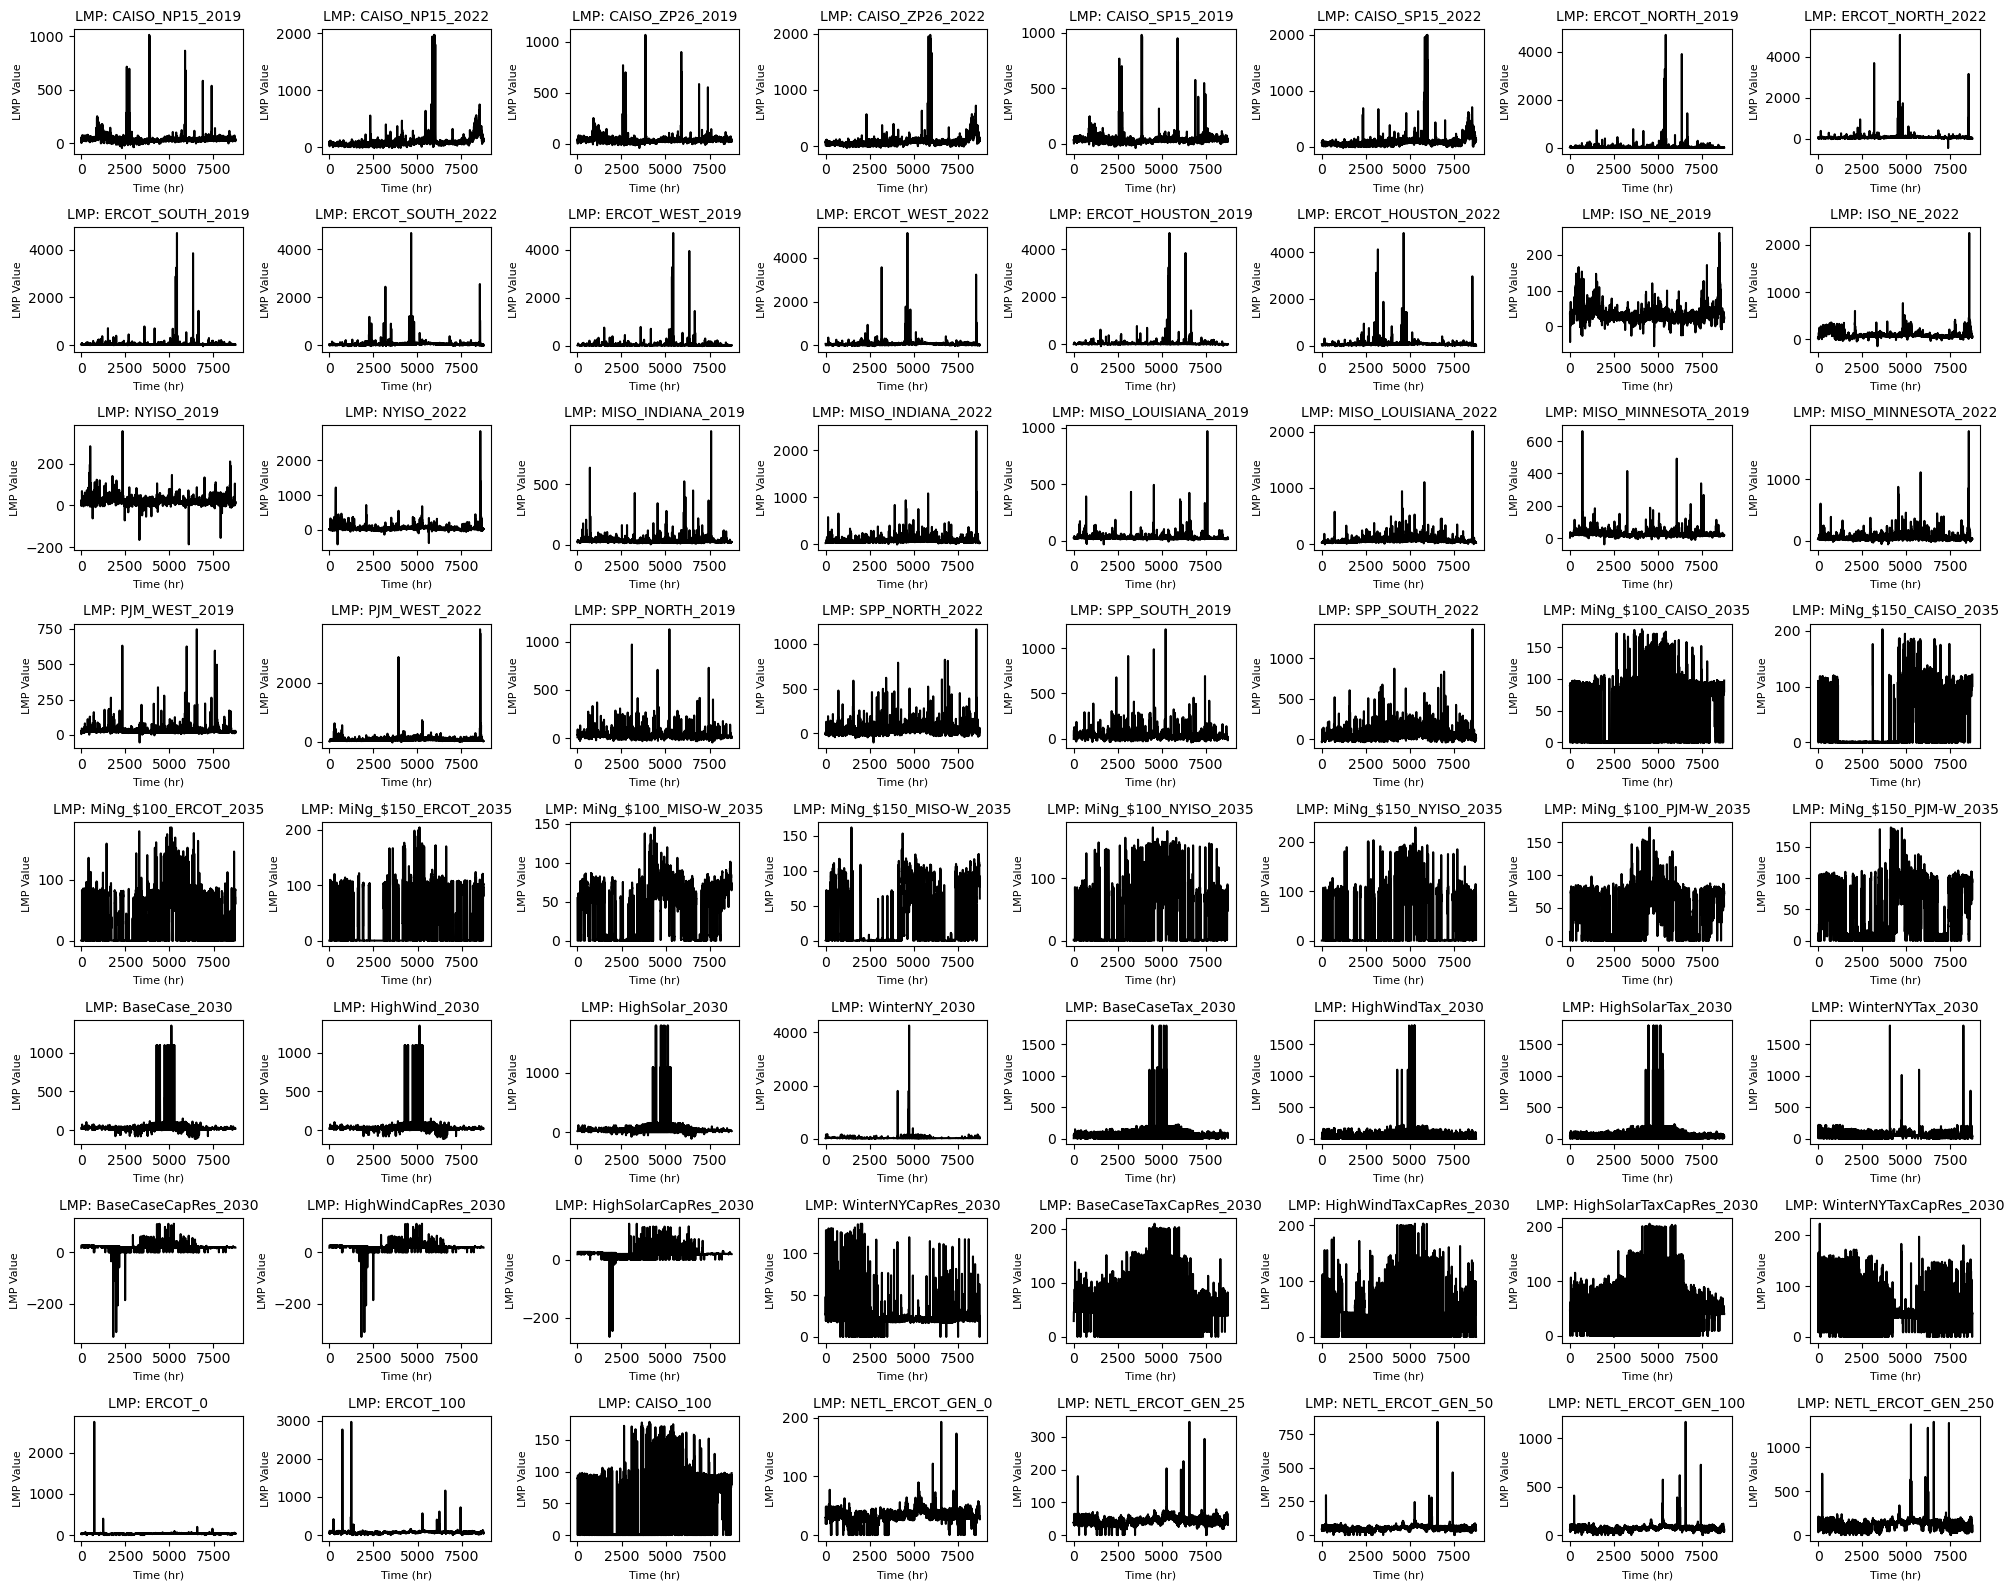

In [11]:
LMP_data = pd.read_csv("lmp_data_loop.csv")


columns_to_plot = LMP_data.columns[1:66]

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 16))
axes = axes.flatten()

for ax, column_name in zip(axes, columns_to_plot):
    # Plot LMP data
    ax.plot(np.arange(len(LMP_data)), LMP_data[column_name], color='k', label='LMP')
    ax.set_xlabel("Time (hr)", fontsize=8)
    ax.set_ylabel("LMP Value", fontsize=8)
    ax.set_title(f"LMP: {column_name}", fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
power_vals_dict = {}

LMP_data = pd.read_csv("lmp_data_loop.csv")


columns_to_plot = LMP_data.columns[1:66]

LMP_data_nan = LMP_data.dropna()

for column_name, model in m_results_m.items():
    try:
        power_vals = []
        for d in range(len(LMP_data_nan[column_name])):
            power_vals.append(pyo.value(model.period[1, d + 1].op_blk.power))
        power_vals_dict[column_name] = power_vals
    except Exception as e:
        logging.error(f"Error processing {column_name}: {e}")

#debug by printing power values for each model
for column_name, power_vals in power_vals_dict.items():
    print(f"Power values for {column_name}: {power_vals[:5]}...")  # Print first 5 values for brevity


fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 16))
axes = axes.flatten()

for ax, column_name in zip(axes, power_vals_dict.keys()):
    # Plot LMP data
    ax.plot(np.arange(len(LMP_data_nan)), LMP_data_nan[column_name], color='k', label='LMP')
    ax.set_xlabel("Time (hr)", fontsize=8)
    ax.set_ylabel("Electricity Cost ($/MWh)", fontsize=8)
    ax.set_title(f"Optimal Power Production Schedule\nalong with LMP: {column_name}", fontsize=8)

    # Create a secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(LMP_data_nan)), power_vals_dict[column_name], color='r', label='Power')
    ax2.set_ylabel("Power production (MWh)", fontsize=8)

    l1, lab1 = ax.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax2.legend(l1 + l2, lab1 + lab2, fontsize=6)

plt.tight_layout()

plt.savefig("pricetaker_SOFC_64.png")

plt.show()


NameError: name 'm_results_m' is not defined

# Save simulation results

In [ ]:
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import pickle
import json
import numpy as np


def save_model_results(m_results_m, filename='model_results.pkl'):
    '''
    Save model results to a file
    
    Arguments:
        m_results_m: dictionary of model results
        filename: name of the file to save to
    '''
    # Create a dictionary to store the extracted data
    save_data = {}
    
    for column_name, model in m_results_m.items():
        if model is None:
            save_data[column_name] = None
            continue
            
        try:
            # Extract power dispatch data
            power_dispatch = []
            for t in model.time:
                if hasattr(model, 'power_dispatch'):
                    power_dispatch.append(pyo.value(model.power_dispatch[t]))
                elif hasattr(model, 'fs') and hasattr(model.fs, 'power_dispatch'):
                    power_dispatch.append(pyo.value(model.fs.power_dispatch[t]))
            
            # Get profit if available
            profit = 0
            if hasattr(model, 'objective'):
                profit = pyo.value(model.objective)
            elif hasattr(model, 'fs') and hasattr(model.fs, 'objective'):
                profit = pyo.value(model.fs.objective)
            
            # Store the extracted data
            save_data[column_name] = {
                'power_dispatch': power_dispatch,
                'profit': profit,
                'time': list(model.time)
            }
            
        except Exception as e:
            print(f"Error saving column {column_name}: {e}")
            save_data[column_name] = None
    
    # Save to file
    with open(filename, 'wb') as f:
        pickle.dump(save_data, f)
    
    print(f"Saved model results to {filename}")

def load_model_results(filename='model_results.pkl'):
    '''
    Load model results from a file
    
    Arguments:
        filename: name of the file to load from
        
    Returns:
        plot_data: dictionary containing processed data for plotting
    '''
    try:
        with open(filename, 'rb') as f:
            save_data = pickle.load(f)
        
        # Process the loaded data into the format needed for plotting
        plot_data = {}
        for column_name, data in save_data.items():
            if data is None:
                continue
                
            plot_data[column_name] = {
                'profit': data['profit'],
                'p_output': sum(data['power_dispatch']),
                'p_capacity': sum(data['power_dispatch']) / (len(data['power_dispatch']) * 650)  # 650 MW nameplate
            }
        
        return plot_data
        
    except FileNotFoundError:
        print(f"File {filename} not found")
        return None
    except Exception as e:
        print(f"Error loading model results: {e}")
        return None
